In [1]:
import re
import string
import warnings
import datetime

import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')

-----------

In [2]:
df_sbuzz = pd.read_csv("syndata/Box Office/twitter_clean.csv")
df_title = pd.read_csv("syndata/Box Office/box_office_clean.csv")

In [3]:
movie_dict = {}
c = 0

for i in df_sbuzz.index:
    if df_sbuzz.at[i, 'title'] not in movie_dict:
        c+=1
        movie_dict[df_sbuzz.at[i, 'title']] = c

for i in df_title.index:
    if df_title.at[i, 'Title'] not in movie_dict:
        c+=1
        movie_dict[df_title.at[i, 'Title']] = c
        
rev_movie_dict = {v:k for k, v in movie_dict.items()}

In [4]:
titles = list(df_title['movie_id_t'].unique())
titles_buzz =  list(df_sbuzz['movie_id_s'].unique())
set_intersection_titles = list(set(titles).intersection(titles_buzz))

In [5]:
df_sbuzz['post_date'] = pd.to_datetime(df_sbuzz['post_date'])
df_title['begin_date'] = pd.to_datetime(df_title['begin_date'])
df_title['end_date'] = pd.to_datetime(df_title['end_date'])

In [6]:
# df_sbuzz.sample(2)

In [7]:
# df_title.sample(2)

--------

# Analysis through feature engineering and visualization

In [8]:
plt.rcParams['figure.figsize'] = [18, 10]
sns.set(color_codes=True)

## Cumulative movie sales in the box office:

First, we see how the box office sales are in general.

In [9]:
agg_cost = df_title.groupby(['Title']).sum()[['gross_to_date_float']].sort_values(
    by='gross_to_date_float', ascending=False)

In [10]:
weekend_to_total = df_title[['Title', 'weekend_gross_float', 'gross_to_date_float']]
weekend_to_total = weekend_to_total.fillna(0)

Performance of weekend sales against total gross: It can been seen that these two variables are negatively correlated. This is expected since as weeks progress other new movies become more popular on the weekend compared to the previous ones.

In [11]:
# weekend sales and gross total are negatively correlated
stats.spearmanr(weekend_to_total['weekend_gross_float'], weekend_to_total['gross_to_date_float'])

SpearmanrResult(correlation=-0.12802988502257107, pvalue=0.04187736925949874)

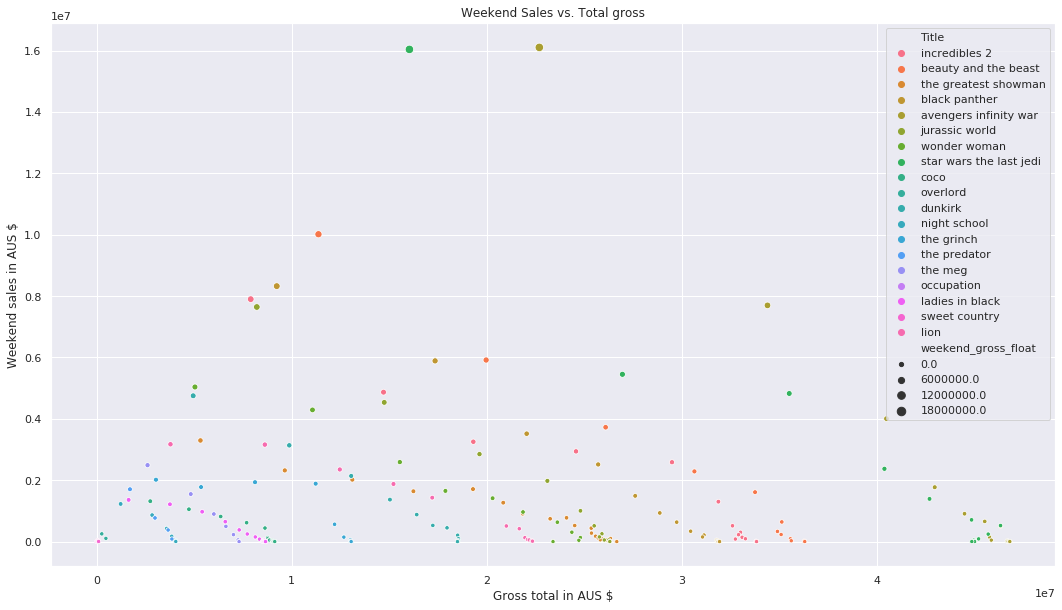

In [12]:
wtt = sns.scatterplot(data=weekend_to_total, hue = "Title", 
                y="weekend_gross_float", x="gross_to_date_float", 
                size="weekend_gross_float");
wtt.set_xlabel("Gross total in AUS $");
wtt.set_ylabel("Weekend sales in AUS $")
wtt.set_title("Weekend Sales vs. Total gross");
# weekend sales are initially high when the movie releases and 
# thereafter it starts declining although total sales keeps increasing

## General Tweets Analysis

Next, we see the overall tweets each movie obtained and also the total sales for each movie. 

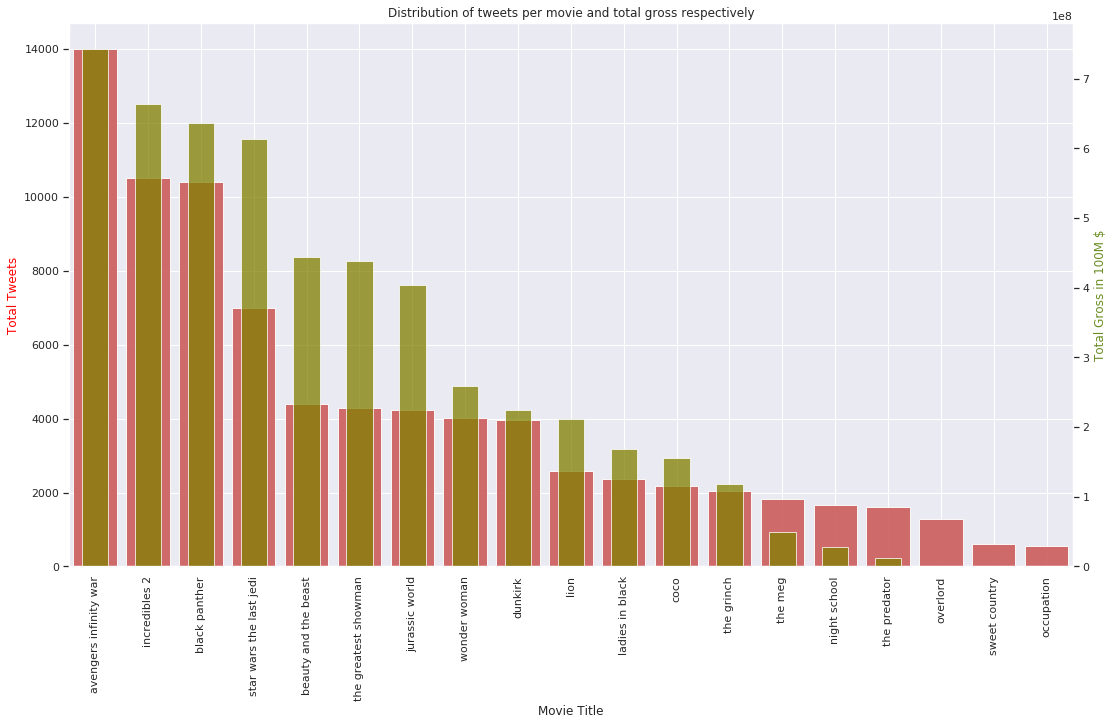

In [13]:
# distribution of tweets per movie and total gross respectively
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Distribution of tweets per movie and total gross respectively")

df_sbuzz['title'].value_counts().plot(kind='bar', ax=ax, width=0.82, color='indianred', alpha=0.9);
ax.set_xlabel("Movie Title")
ax.set_ylabel("Total Tweets");
ax.yaxis.label.set_color('red')

ax2 = ax.twinx()

agg_cost.plot(kind='bar', legend=False, ax=ax2, color='olive', alpha=0.75)
ax2.set_xlabel("Movie Title")
ax2.set_ylabel("Total Gross in 100M $");
ax2.yaxis.label.set_color('olivedrab')
ax2.grid(False)

# for p in ax.patches:
#     ax.annotate(str(int(p.get_height())), (p.get_x()*1.004, p.get_height()*1.01), rotation=20)

While this does tell the relative popularity between different movies preferred by people, it does not shed any light on if tweets affect the movie performance in the box office.

### Sales distributed across weeks

In this section, we see how the overall sales performs in the weeks following its release.

In [14]:
by_week = (df_title
            .groupby(['Title', 'Week # of release'])
            .size()
            .unstack())

In [15]:
for idx in by_week.index:
    for col in by_week.columns:
        
        try:
            by_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['Week # of release']==col)]['gross_to_date_float'])
        except:
            by_week.at[idx, col] = np.nan


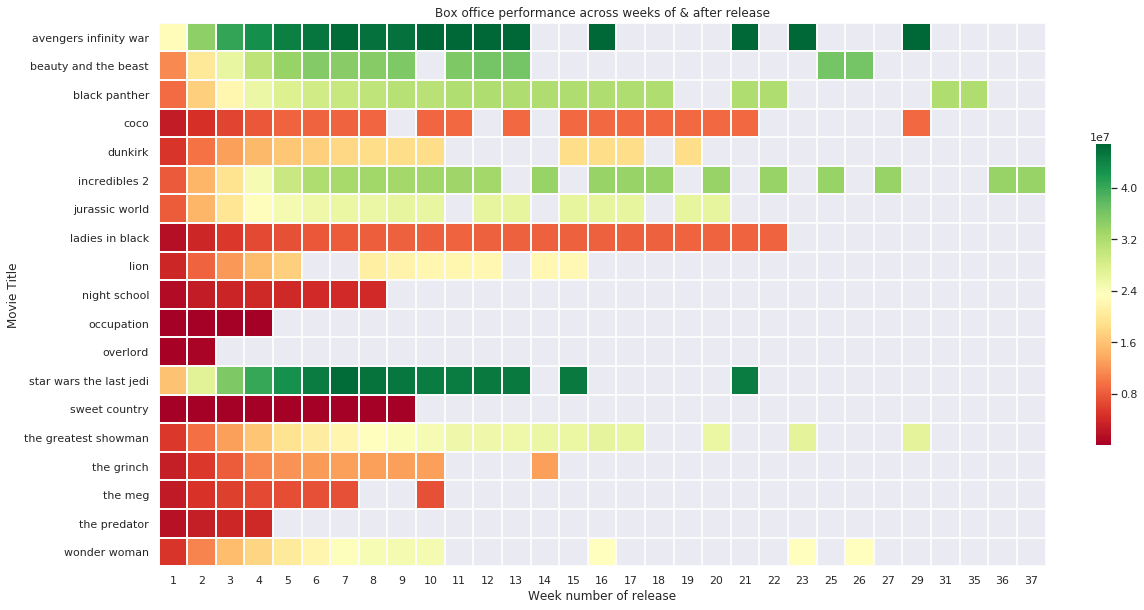

In [54]:
plt.figure(figsize=(18,10))
week_releases = sns.heatmap(
    by_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1,
    linecolor="#fbfbfb"
)
week_releases.set_xlabel("Week number of release")
week_releases.set_ylabel("Movie Title")
week_releases.set_title("Box office performance across weeks of & after release");
# given box office sales for movies that have only performed good, i.e. sales keep increasing after every week

In general, the overall sales for all movies keep increasing over time. 

*This can also be because of the kind of movies selected, i.e. movies that perform well in the box office. The exceptions to this case may be movies that don't last longer than 4 weeks in the box office like - ***Occupation***, ***Overlord*** & ***The Predator***. Additionally, movies like ***Sweet Country*** and ***Night School*** although run longer than 4 weeks, their overall sales are satuared from early on implying less popularity.*

### Do tweets effect sales?

We now see if __the number of tweets__ received per movie affects the box office performance.

In [17]:
# grouping movies by count of tweets received
tweets_per_movie_date = df_sbuzz.groupby(['movie_id_s', 'title', 'post_date']).size().unstack(1)

In [18]:
box_vs_tweets = df_title[['movie_id_t', 'Title', 'Week # of release', 
                          'begin_date', 'end_date', 'gross_to_date_float', 'weekend_gross_float']]

In [19]:
box_vs_tweets["tweets_received"] = 0

In [20]:
for m_id, time in tweets_per_movie_date.index:
    curr_df = box_vs_tweets[box_vs_tweets['movie_id_t']==m_id]
    for idx in curr_df.index:
        
        if curr_df.at[idx, 'begin_date'] < time < curr_df.at[idx, 'end_date']:
            box_vs_tweets.at[idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]

        if curr_df.at[idx, 'begin_date'] > time or curr_df.at[idx, 'begin_date'] < time:
            new_idx = len(box_vs_tweets)+1
            box_vs_tweets.at[new_idx, 'begin_date'] = time.date()
            box_vs_tweets.at[new_idx, 'end_date'] = time.date()
            box_vs_tweets.at[new_idx, 'Title'] = rev_movie_dict[m_id]
            box_vs_tweets.at[new_idx, 'movie_id_t'] = m_id
            box_vs_tweets.at[new_idx, 'tweets_received'] = tweets_per_movie_date.loc[(m_id, time), rev_movie_dict[m_id]]
        
    box_vs_tweets.drop_duplicates(inplace=True)

In [21]:
# tweets_per_movie_date

In [22]:
box_vs_tweets = (box_vs_tweets
                 .sort_values(by=['movie_id_t', 'begin_date'])
                 .reset_index()
                 .drop(axis=1, labels=['index'])
                 .fillna(0))

In [23]:
# box_vs_tweets.sort_values(by='tweets_received', ascending=False).head(10)

A new feature called `rel_week_release` is introduced which gives the relative week number values to days post and prior to the release week. The release week has `rel_week_release=1` and the week before it is -1 while the week after it is 2 and so on.

In [24]:
box_vs_tweets["rel_week_release"] = 0

for key in set_intersection_titles:
    d = box_vs_tweets[box_vs_tweets['movie_id_t']==key]
    
    # assuming first starts with 1st week of release by default

    indicator = 1
    first = list(d[d['Week # of release']==indicator]['begin_date'])[0]

    for ix in d.index:
        
        if d.at[ix, 'rel_week_release'] == 0:
                        
            if d.at[ix, 'begin_date'] == first:
                box_vs_tweets.at[ix, 'rel_week_release'] =  indicator

            elif d.at[ix, 'begin_date'] < first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_tweets.at[ix, 'rel_week_release'] =  (delta_days/7).days 

            elif d.at[ix, 'begin_date'] > first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_tweets.at[ix, 'rel_week_release'] =  (delta_days/7).days + 1

In [25]:
bvt = box_vs_tweets.drop(axis=1, labels=['Week # of release', 'begin_date', 'end_date'])

In [26]:
# bvt.sort_values(by='tweets_received', ascending=False).tail(20)

In [27]:
bvt2 = (bvt.groupby(['Title', 'rel_week_release'])['tweets_received'].sum().unstack(-1))

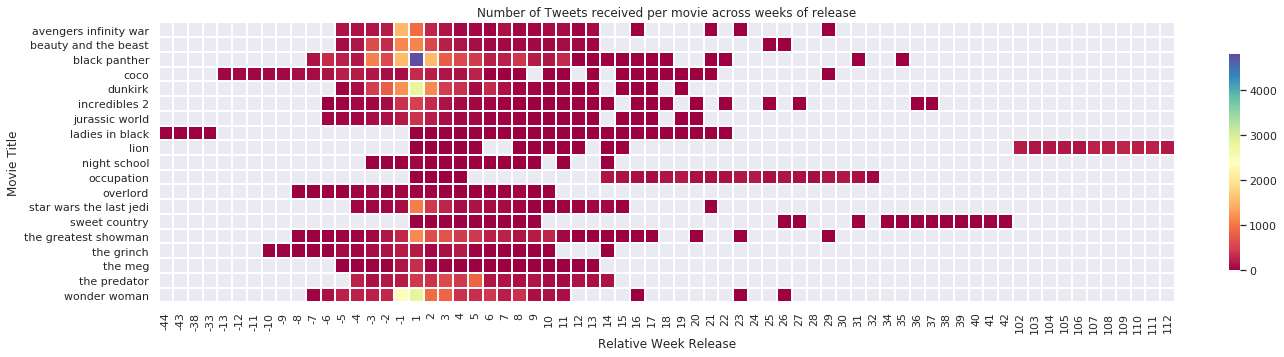

In [28]:
# number of tweets varying as weeks progress in the box office
qwt = sns.heatmap(
    bvt2, 
    square=True, 
    cbar_kws={'fraction' : 0.01}, 
    cmap='Spectral',
    linewidth=1 
);
qwt.set_xlabel("Relative Week Release")
qwt.set_ylabel("Movie Title")
qwt.set_title("Number of Tweets received per movie across weeks of release")
plt.tight_layout()

The overall perspective doesn't give sufficient information since it generalizes on extreme scales (0 - 2000 tweets). Therefore, we see it more in depth per movie in distinct graphs.

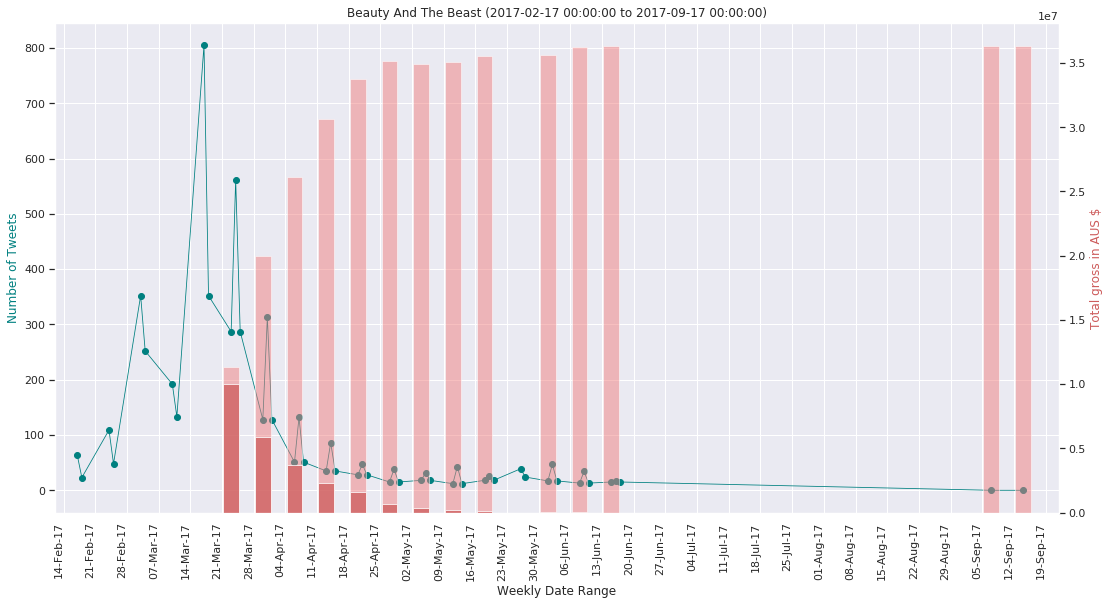

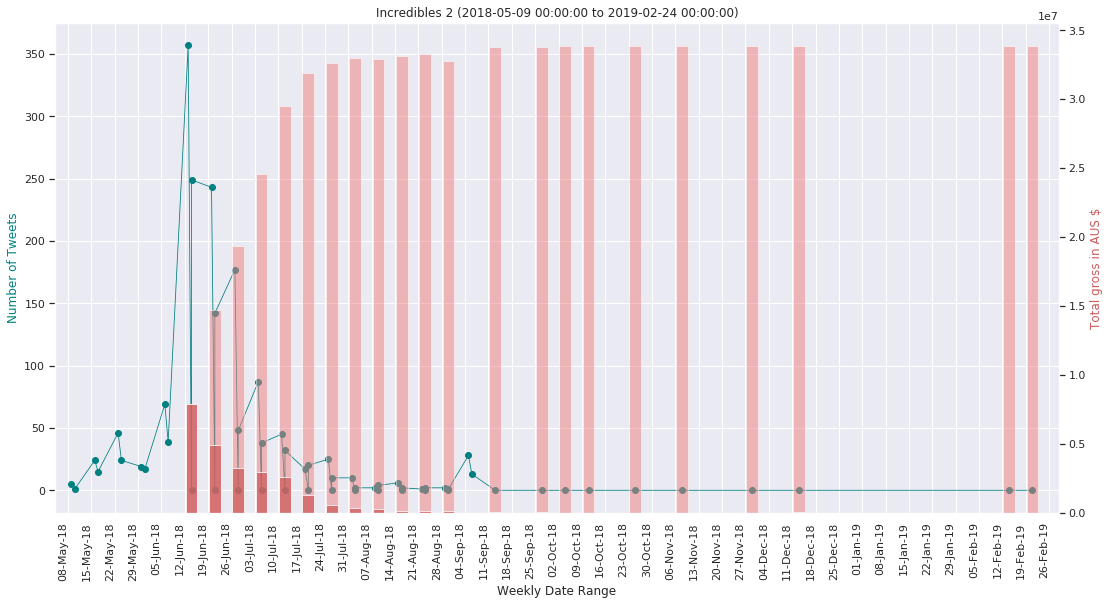

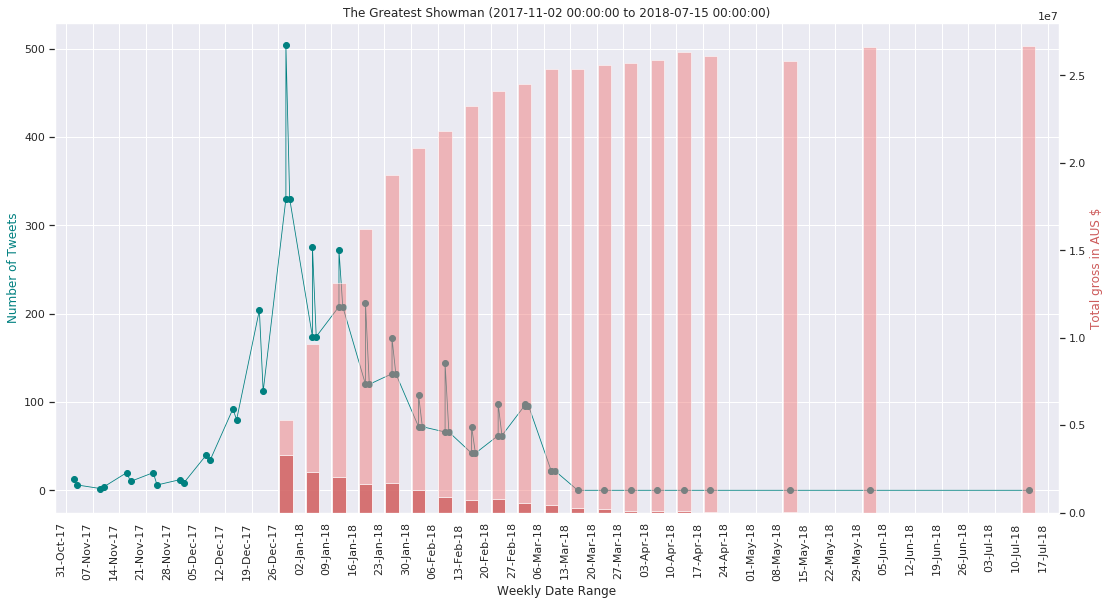

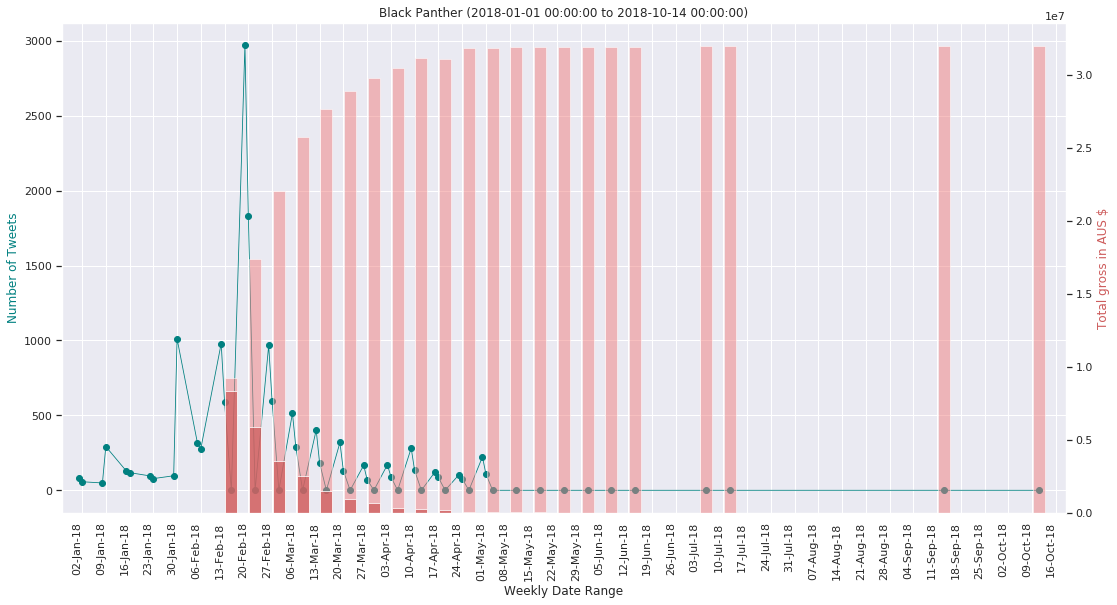

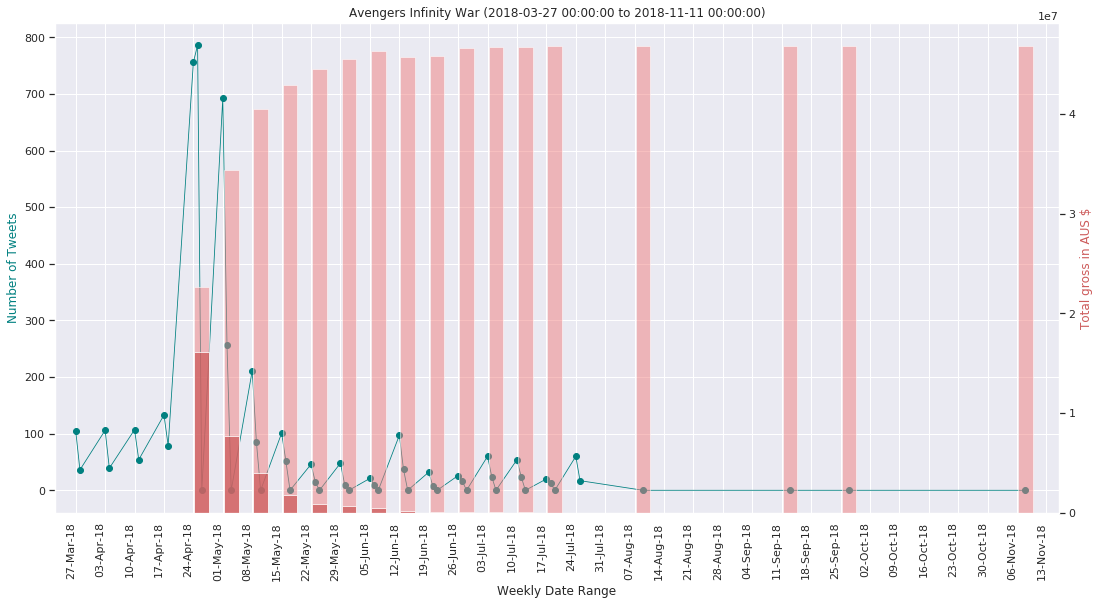

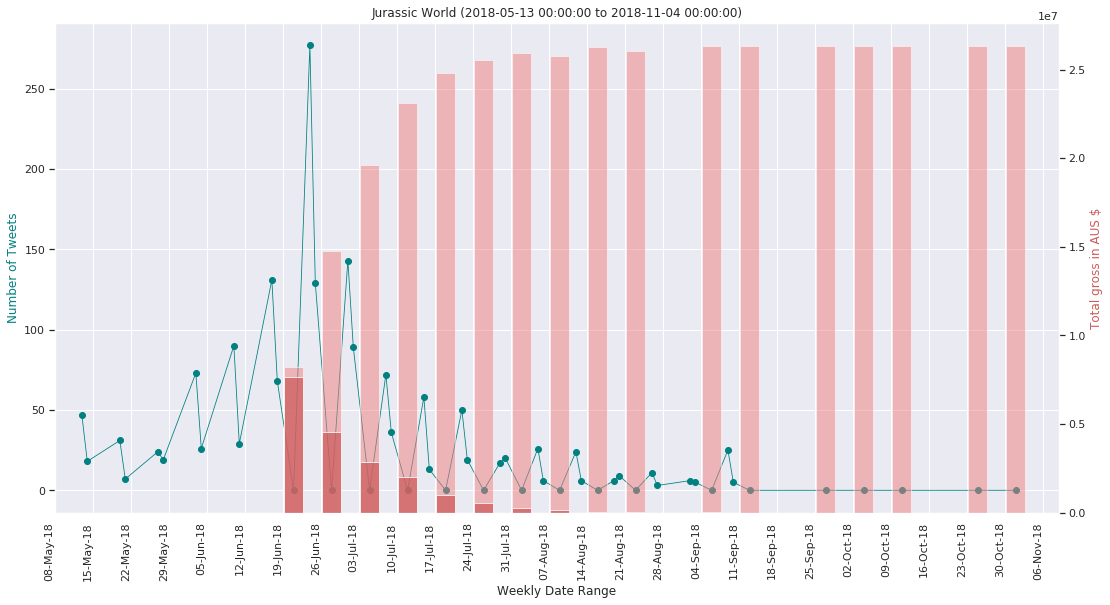

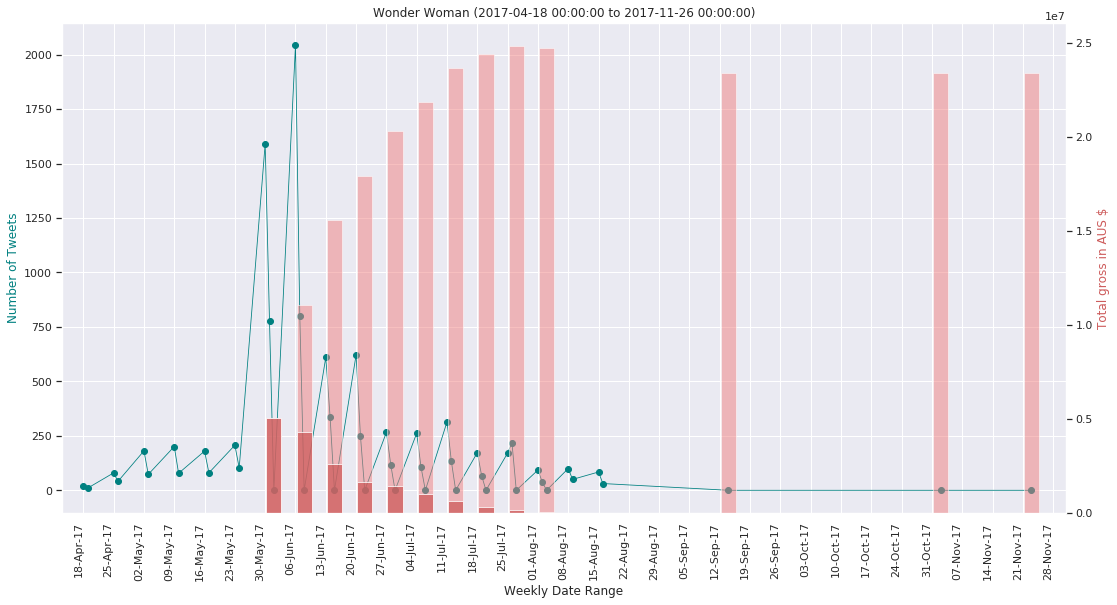

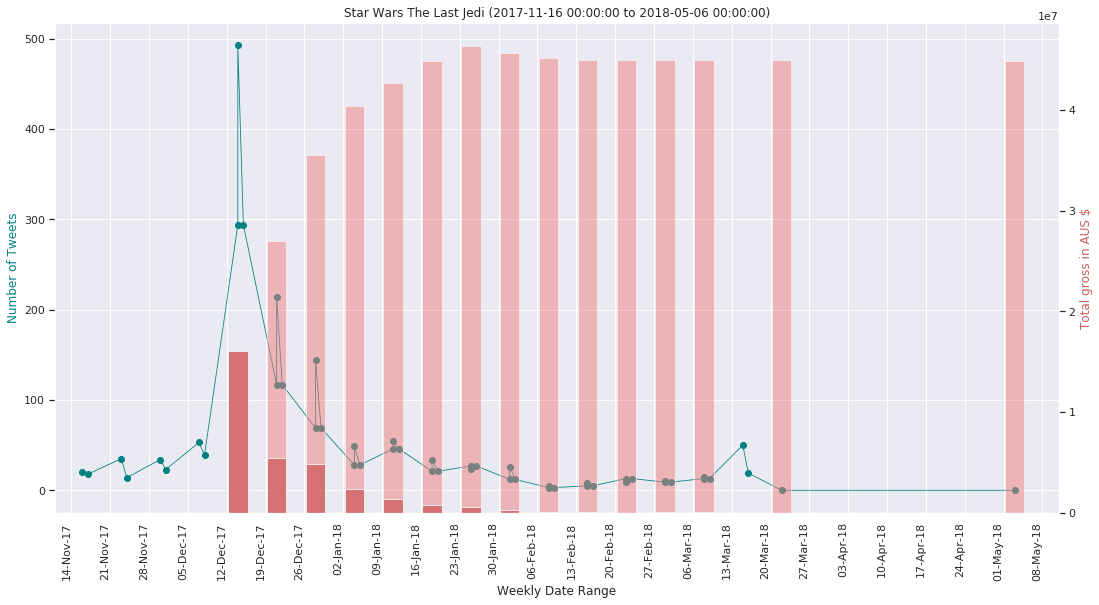

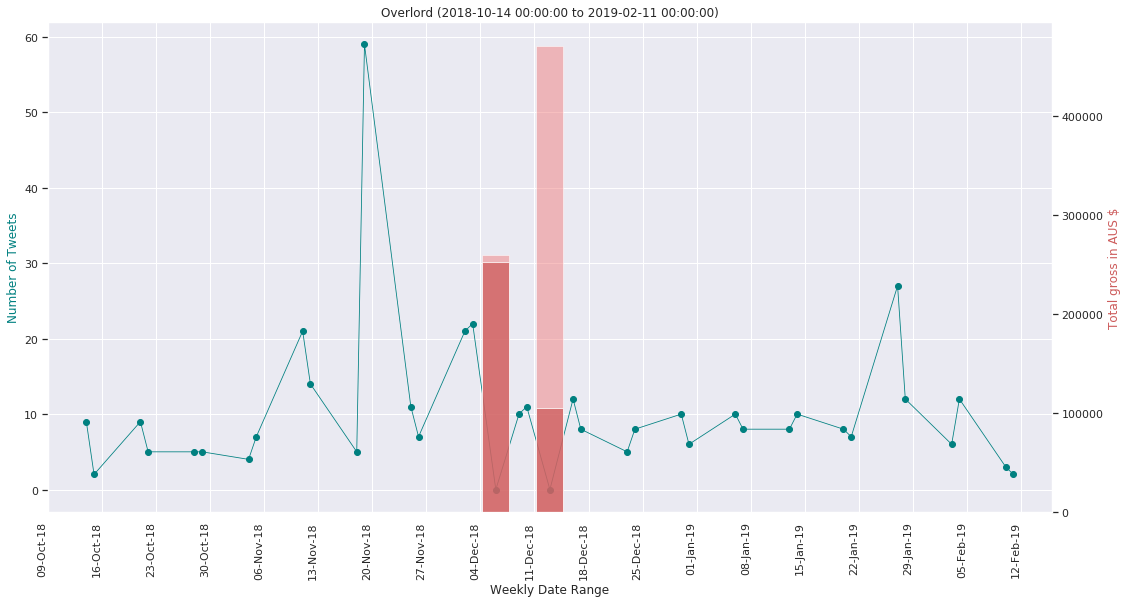

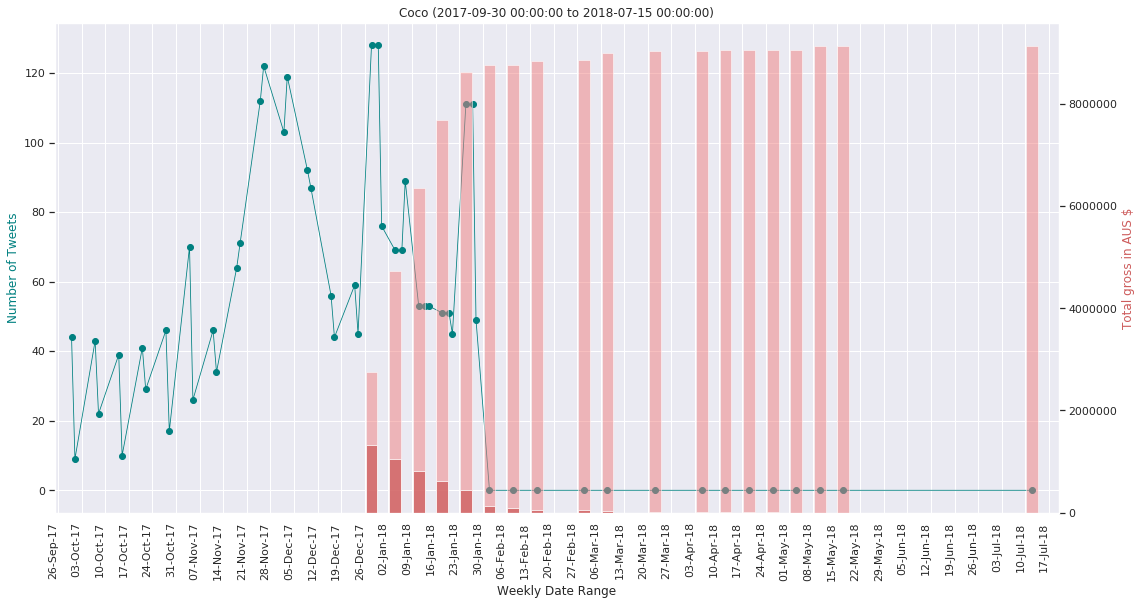

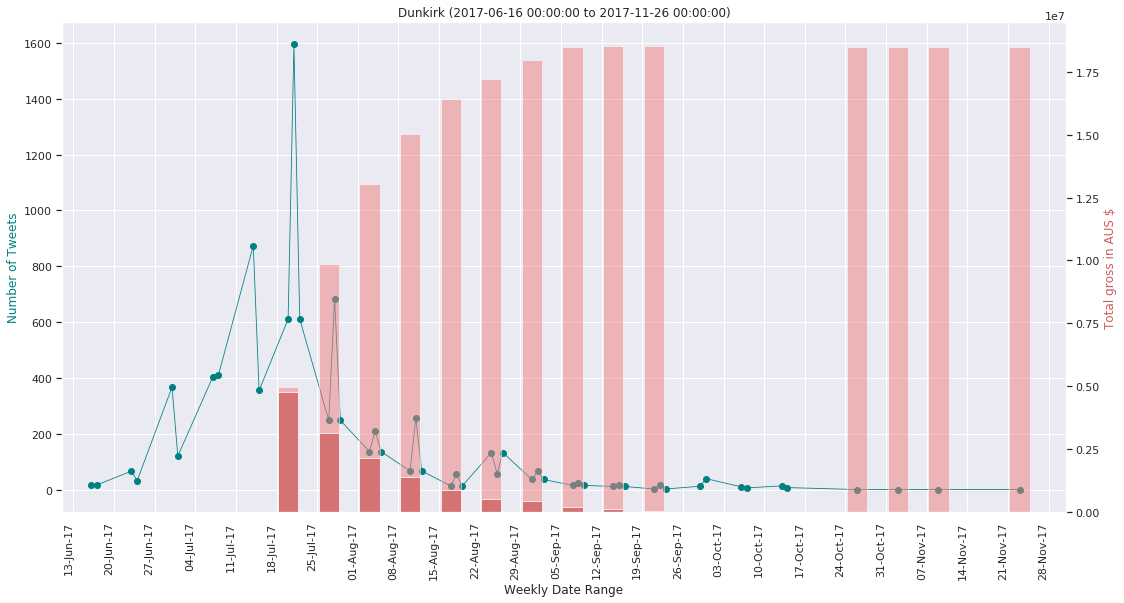

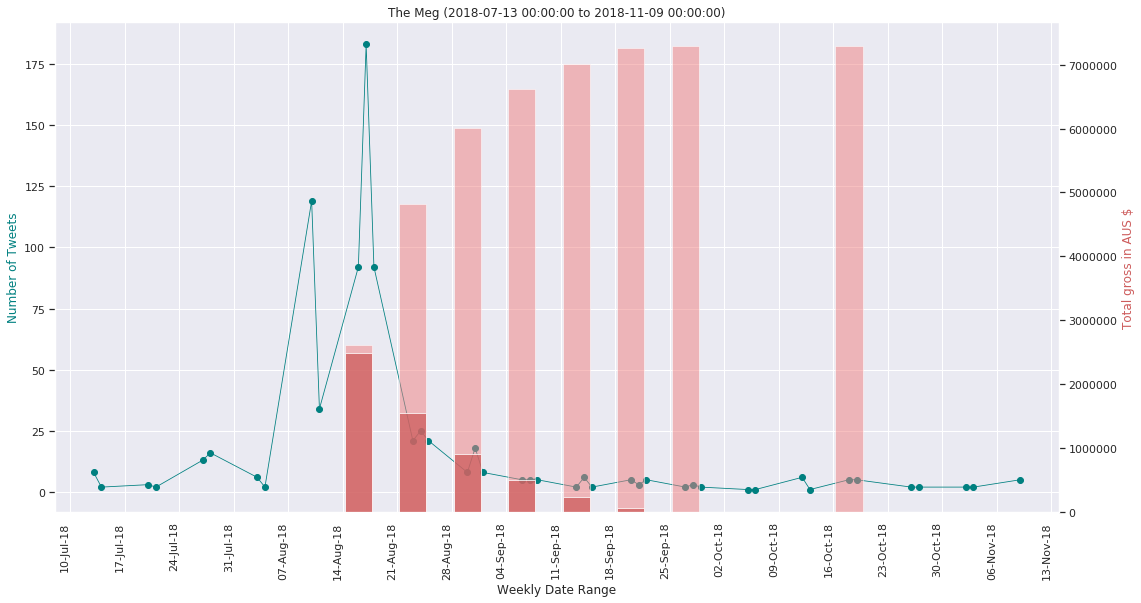

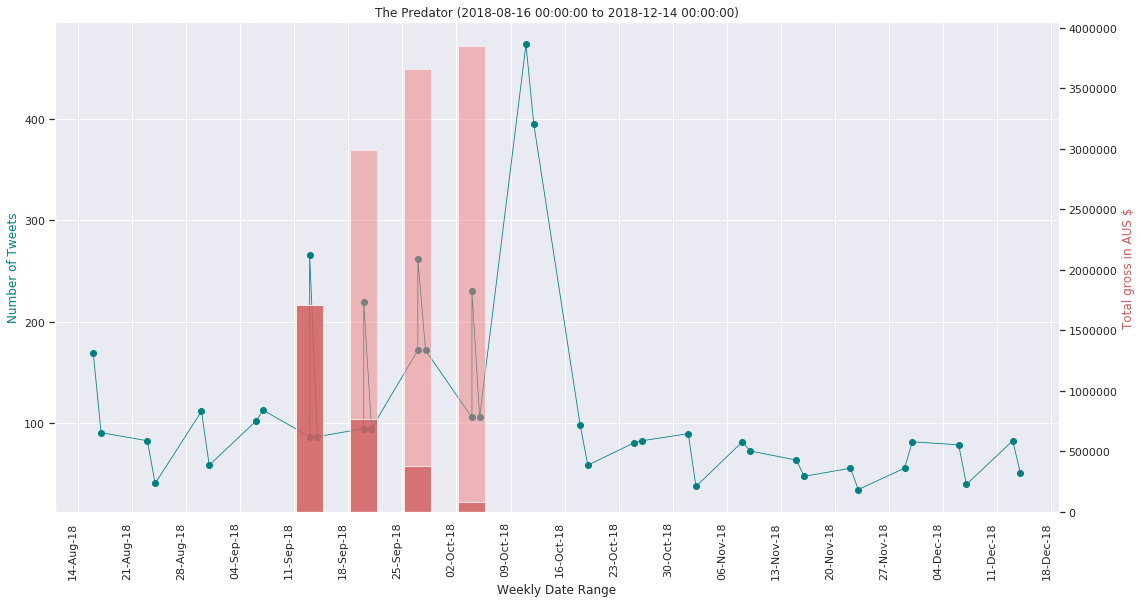

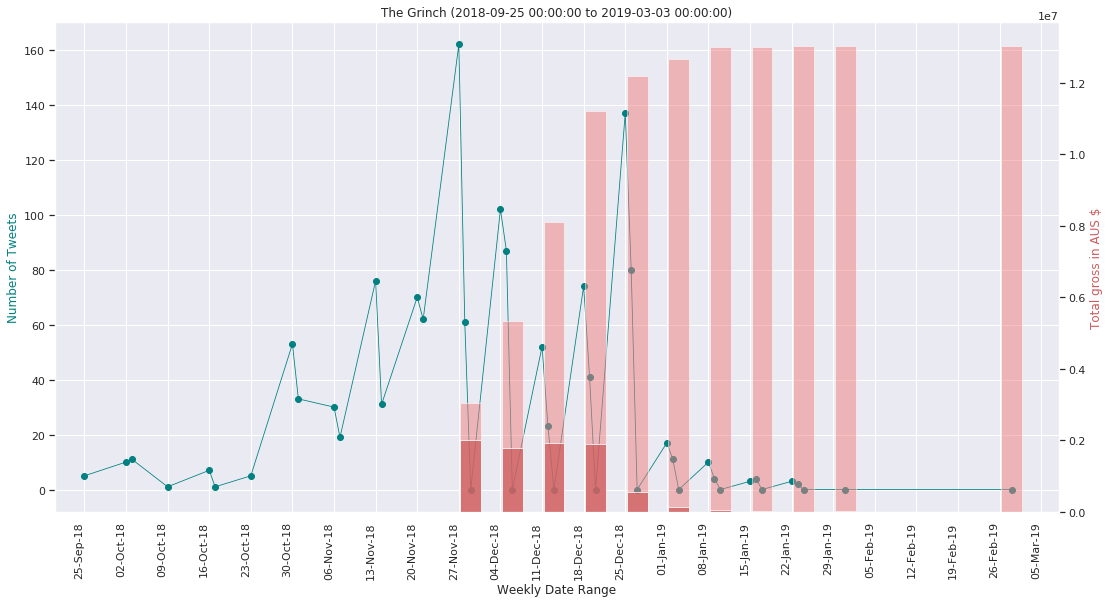

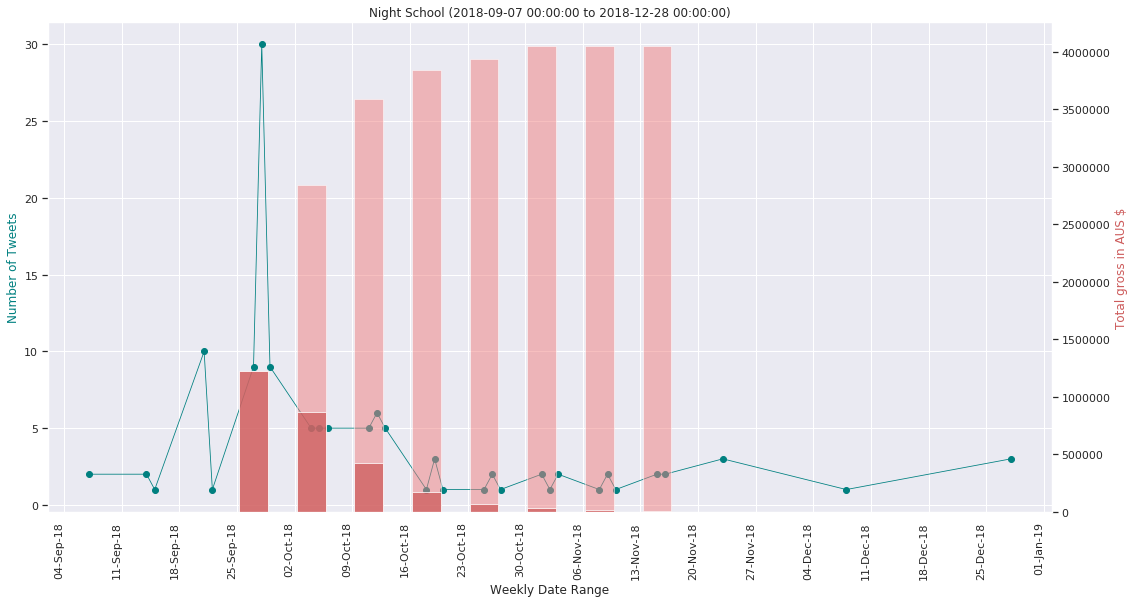

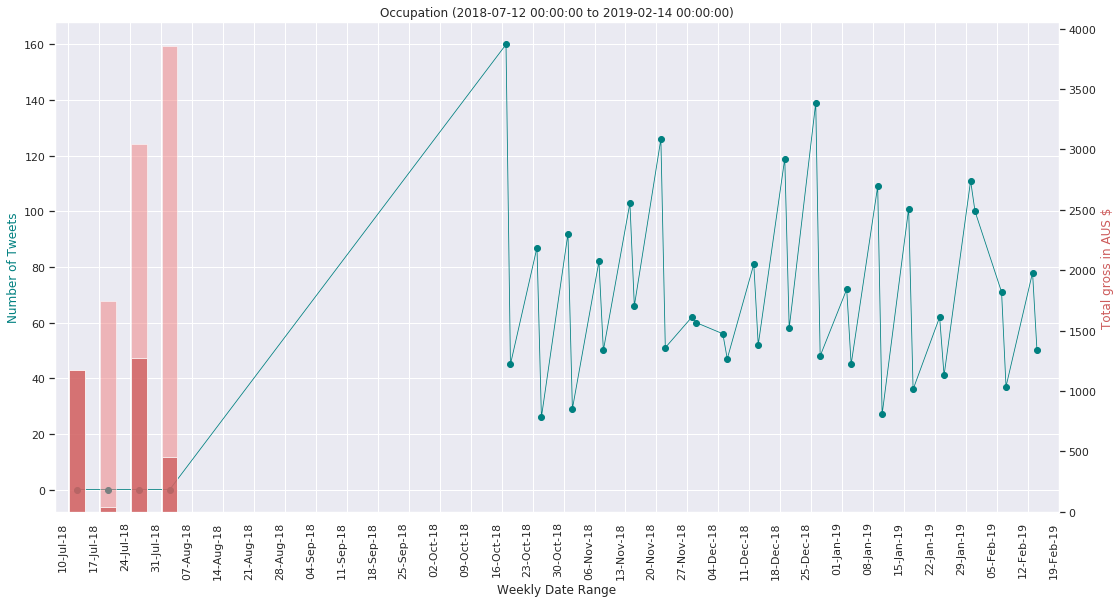

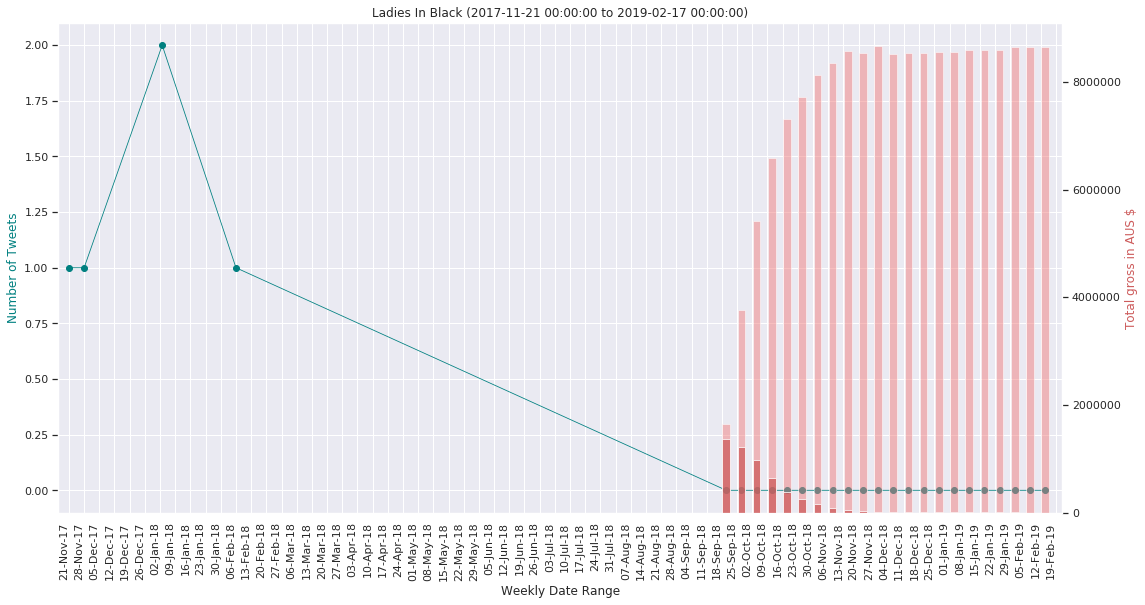

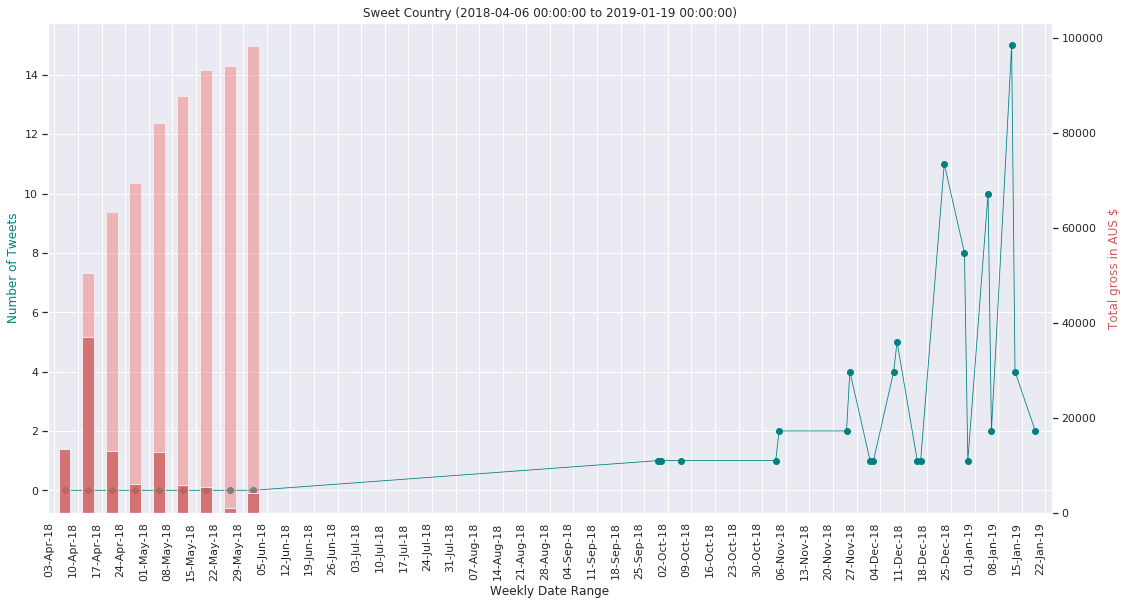

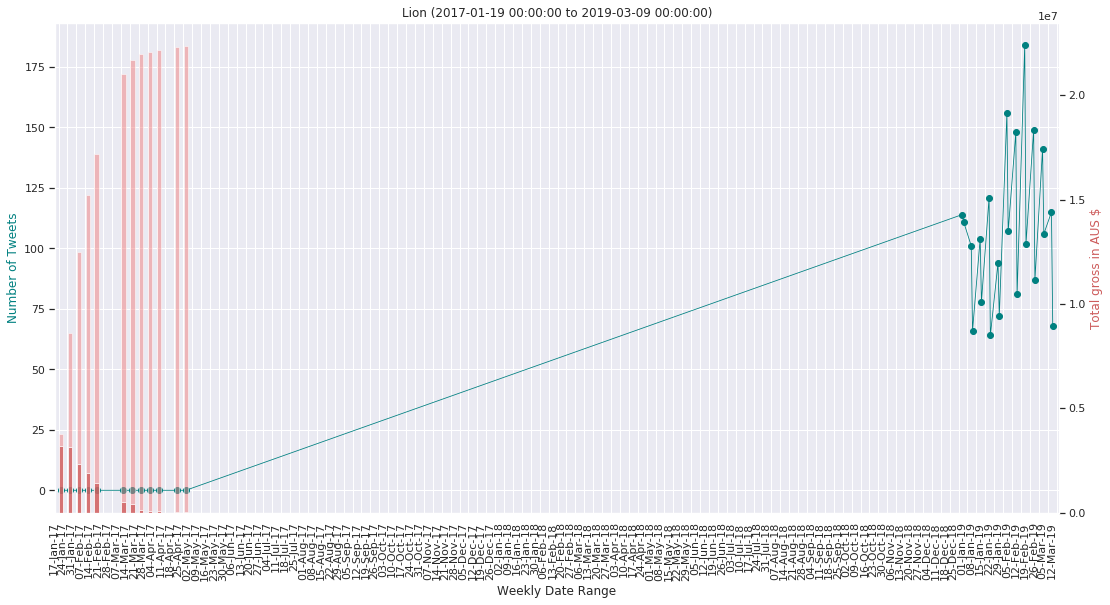

In [29]:
for group in box_vs_tweets.groupby(['movie_id_t']):
    
    # plot for each movie individually
    # change plotting visual style.
    
    date_form = DateFormatter("%d-%b-%y")
    
    mini = group[1]
    start_date_lim = mini['begin_date'].iloc[0] - datetime.timedelta(days=5)
    end_date_lim = mini['end_date'].iloc[len(mini)-1] + datetime.timedelta(days=5)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.set_title("{} ({} to {})".format(string.capwords(mini['Title'].iloc[0]), mini['begin_date'].iloc[0], mini['end_date'].iloc[len(mini)-1]))
    ax1.plot(mini['begin_date'], mini['tweets_received'], color="teal", marker="o", linewidth=0.8)
    ax1.set_ylabel("Number of Tweets")
    ax1.yaxis.label.set_color('teal')

    ax2 = ax1.twinx()
    ax2.bar(x=mini['begin_date'], height=mini['gross_to_date_float'], width=3.5, alpha=0.5, color="lightcoral")
    ax2.bar(x=mini['begin_date'], height=mini['weekend_gross_float'], width=3.5, alpha=0.75, color="indianred")
    ax2.set_ylabel("Total gross in AUS $")
    ax2.yaxis.label.set_color('indianred')
    ax2.grid(False)

    ax1.set_xlabel("Weekly Date Range")

    # Define the date format
    fig.autofmt_xdate(rotation=90)

    ax1.set_xlim([start_date_lim, end_date_lim])

    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

### Sentiment of tweets

In [30]:
sub = df_sbuzz[['movie_id_s', 'title', 'post_date', 'tweet_sentiment']]

In [31]:
# print(stats.mode(sub['tweet_sentiment']).mode)
# print(np.mean(sub['tweet_sentiment']))
# print(np.median(sub['tweet_sentiment']))

In [32]:
# mini = sub.groupby(['movie_id_s', 'title', 'post_date'])['tweet_sentiment'].agg(pd.Series.mode).unstack(1)
mini = sub.groupby(['movie_id_s', 'title', 'post_date'])['tweet_sentiment'].mean().unstack(1)

In [33]:
# mini

In [34]:
box_vs_sentiment = df_title[['movie_id_t', 'Title', 'Week # of release','begin_date', 'end_date', 'gross_to_date_float', 'weekend_gross_float']]

In [35]:
box_vs_sentiment['tweet_sentiment'] = 0

In [36]:
for m_id, time in mini.index:
    curr_df = box_vs_sentiment[box_vs_sentiment['movie_id_t']==m_id]
    for idx in curr_df.index:
        
        if curr_df.at[idx, 'begin_date'] < time < curr_df.at[idx, 'end_date']:
            box_vs_sentiment.at[idx, 'tweet_sentiment'] = np.mean(mini.loc[(m_id, time), rev_movie_dict[m_id]])

        if curr_df.at[idx, 'begin_date'] > time or curr_df.at[idx, 'begin_date'] < time:
            new_idx = len(box_vs_sentiment)+1
            box_vs_sentiment.at[new_idx, 'begin_date'] = time.date()
            box_vs_sentiment.at[new_idx, 'end_date'] = time.date()
            box_vs_sentiment.at[new_idx, 'Title'] = rev_movie_dict[m_id]
            box_vs_sentiment.at[new_idx, 'movie_id_t'] = m_id
            box_vs_sentiment.at[new_idx, 'tweet_sentiment'] = np.mean(mini.loc[(m_id, time), rev_movie_dict[m_id]])
        
    box_vs_sentiment.drop_duplicates(inplace=True)

In [37]:
box_vs_sentiment = (box_vs_sentiment
                 .sort_values(by=['movie_id_t', 'begin_date'])
                 .reset_index()
                 .drop(axis=1, labels=['index'])
                 .fillna(0))

In [38]:
box_vs_sentiment["rel_week_release"] = 0

for key in set_intersection_titles:
    d = box_vs_sentiment[box_vs_sentiment['movie_id_t']==key]
    
    # assuming first starts with 1st week of release by default

    indicator = 1
    first = list(d[d['Week # of release']==indicator]['begin_date'])[0]

    for ix in d.index:
        
        if d.at[ix, 'rel_week_release'] == 0:
                        
            if d.at[ix, 'begin_date'] == first:
                box_vs_sentiment.at[ix, 'rel_week_release'] =  indicator

            elif d.at[ix, 'begin_date'] < first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_sentiment.at[ix, 'rel_week_release'] =  (delta_days/7).days 

            elif d.at[ix, 'begin_date'] > first:
                delta_days = d.at[ix, 'begin_date'] - first
                box_vs_sentiment.at[ix, 'rel_week_release'] =  (delta_days/7).days + 1

In [39]:
# box_vs_sentiment

In [40]:
bvs2 = box_vs_sentiment.drop(axis=1, labels=['Week # of release', 'begin_date', 'end_date'])

In [41]:
ff2 = (bvs2.groupby(['Title', 'rel_week_release'])['tweet_sentiment'].mean().unstack(-1))

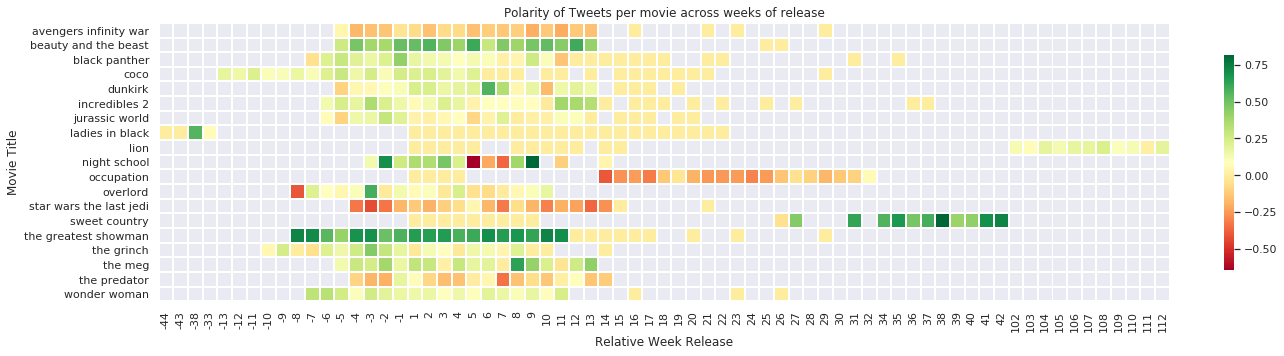

In [51]:
# sentiments varying as weeks progress in the box office
hgf = sns.heatmap(
    ff2, 
    square=True, 
    cbar_kws={'fraction' : 0.01}, 
    cmap='RdYlGn',
    linewidth=1 
);
hgf.set_xlabel("Relative Week Release")
hgf.set_ylabel("Movie Title")
hgf.set_title("Polarity of Tweets per movie across weeks of release")
plt.tight_layout()

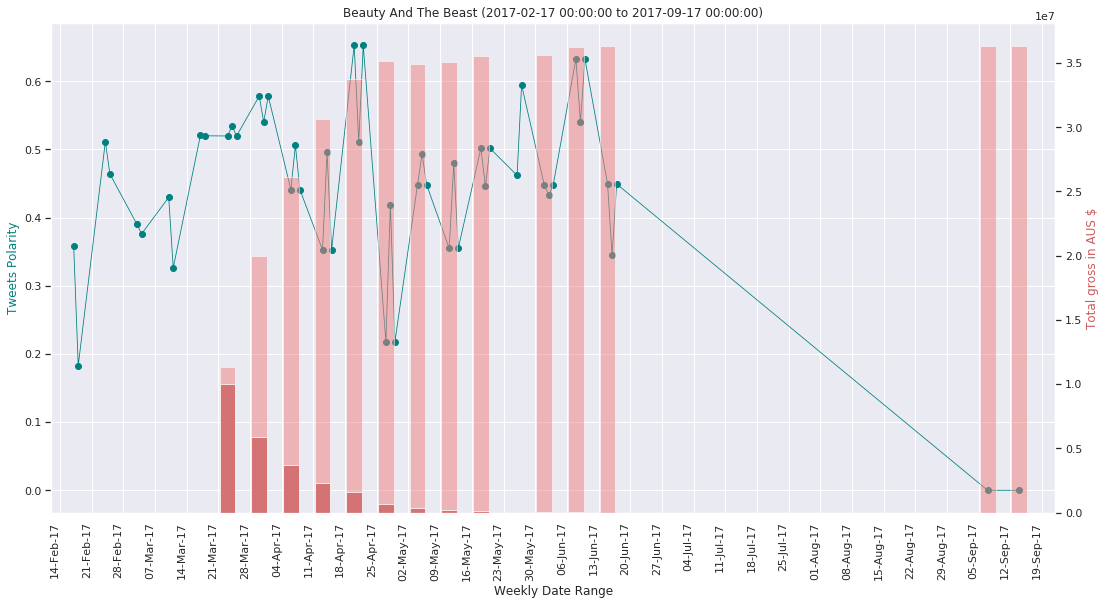

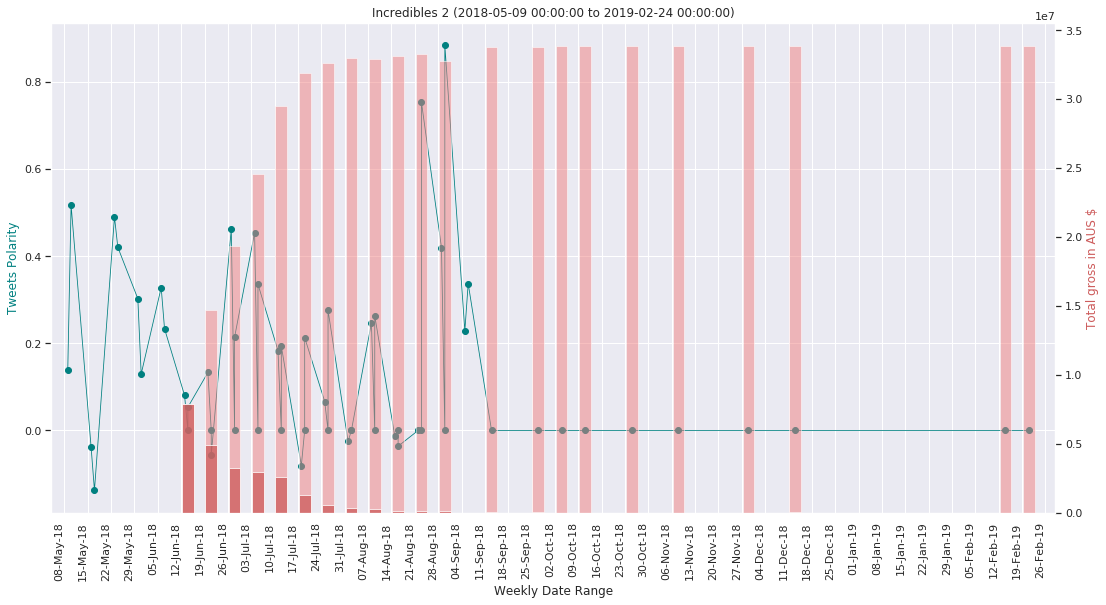

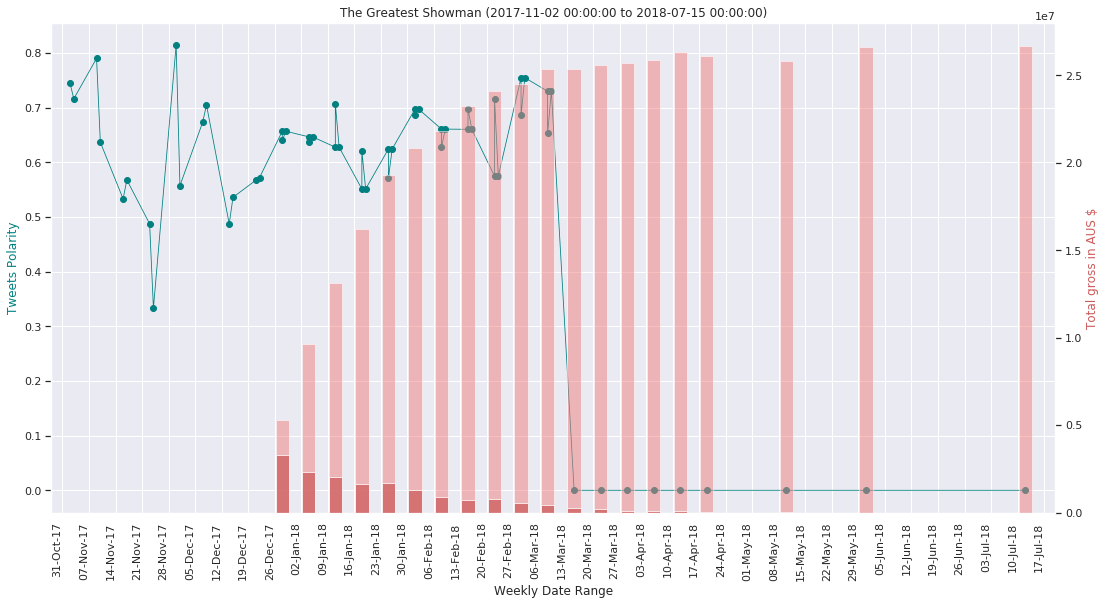

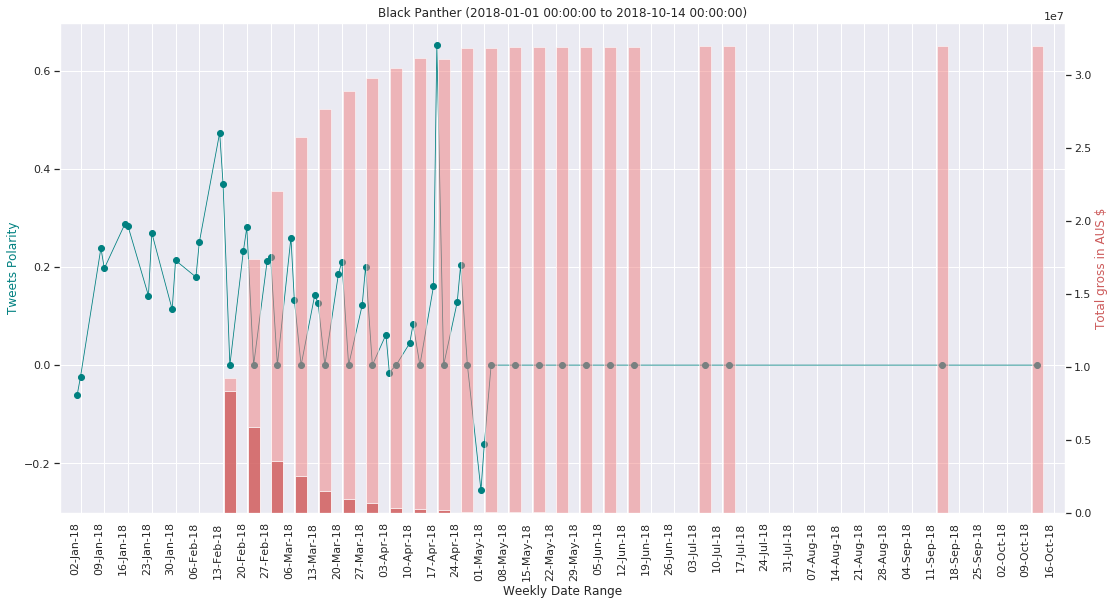

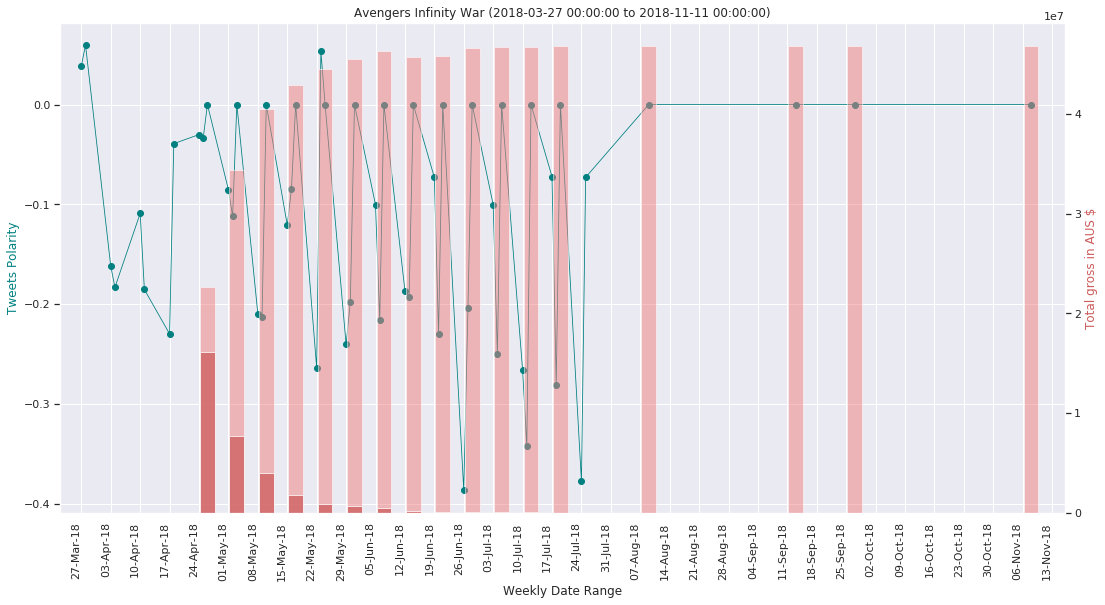

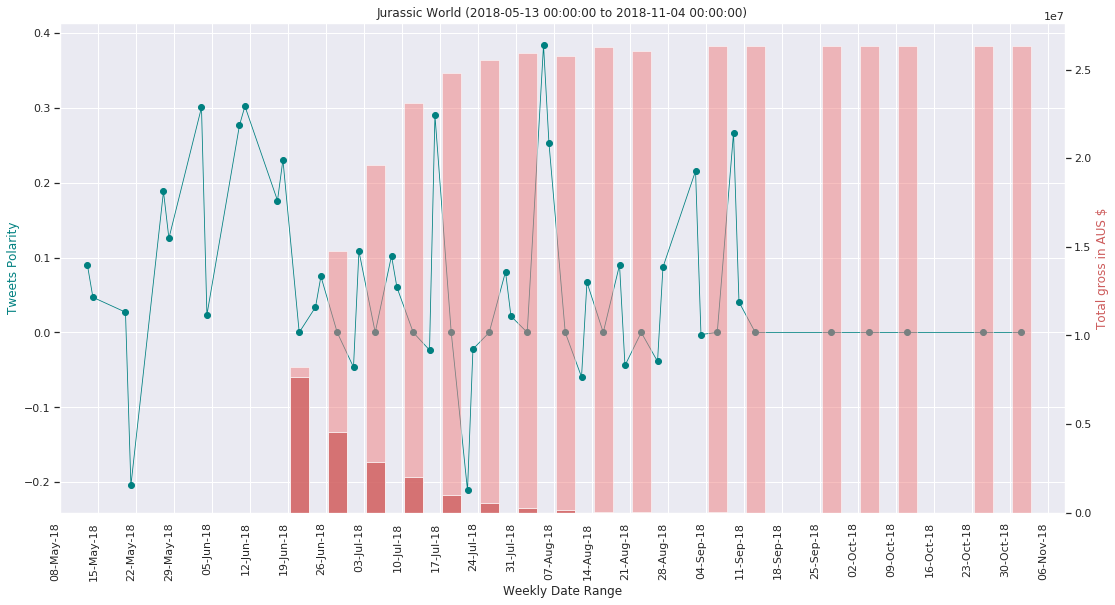

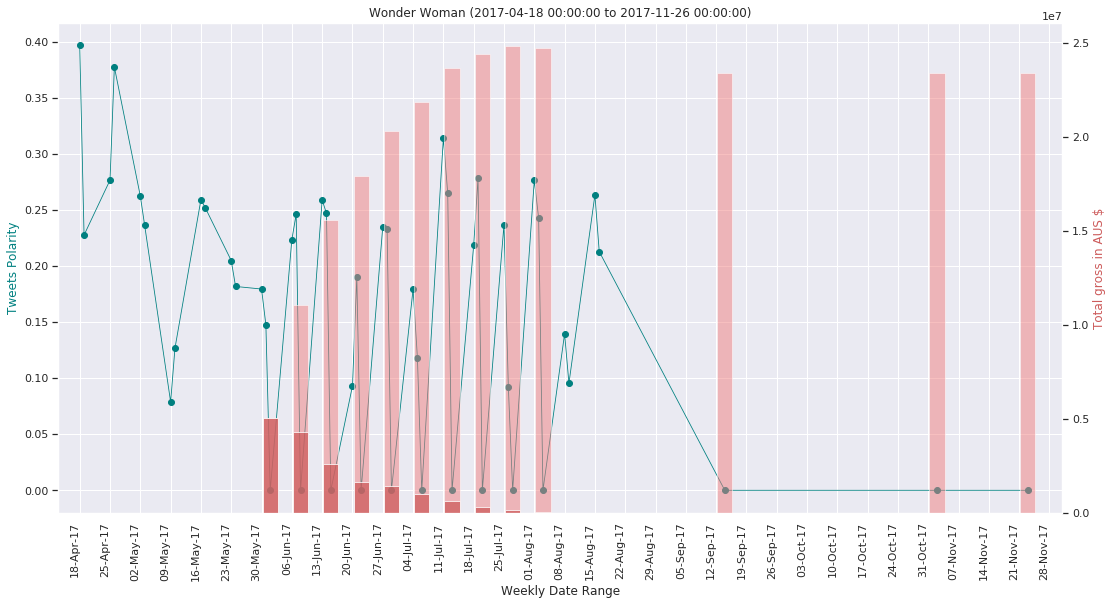

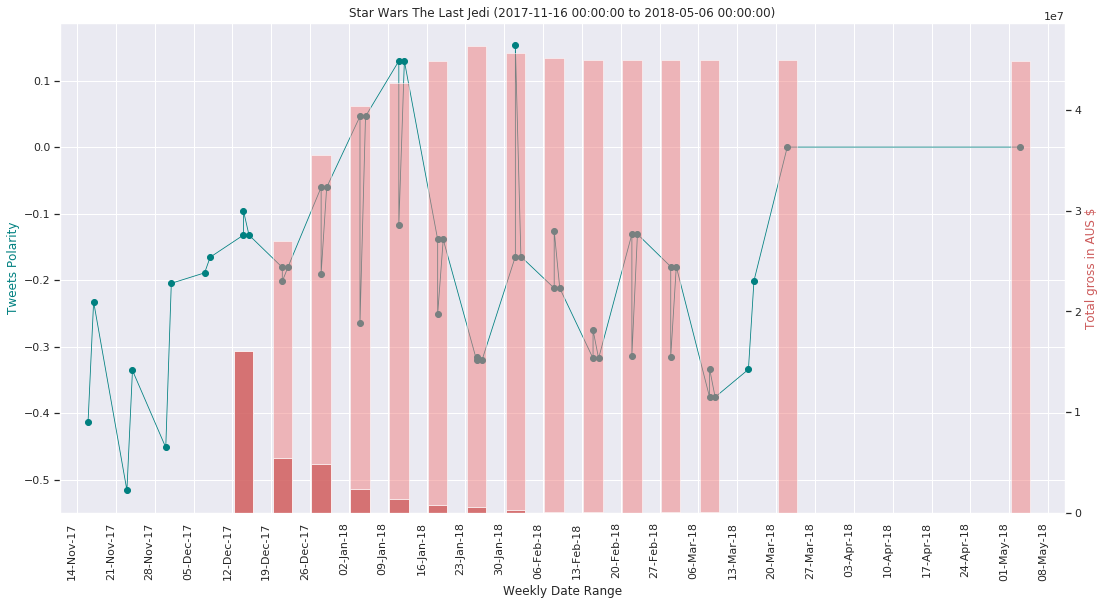

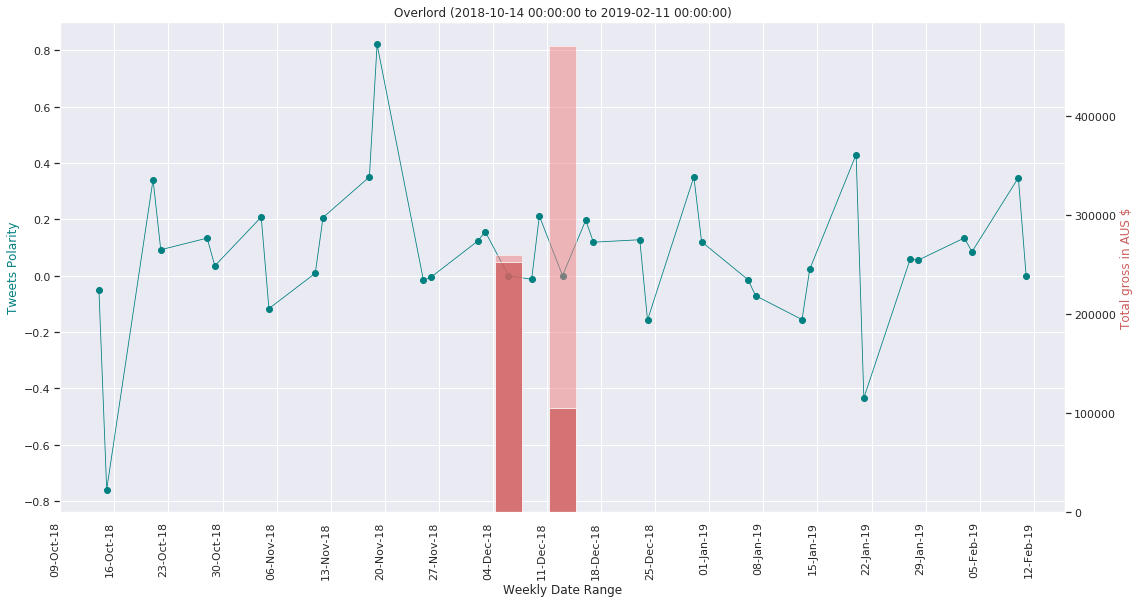

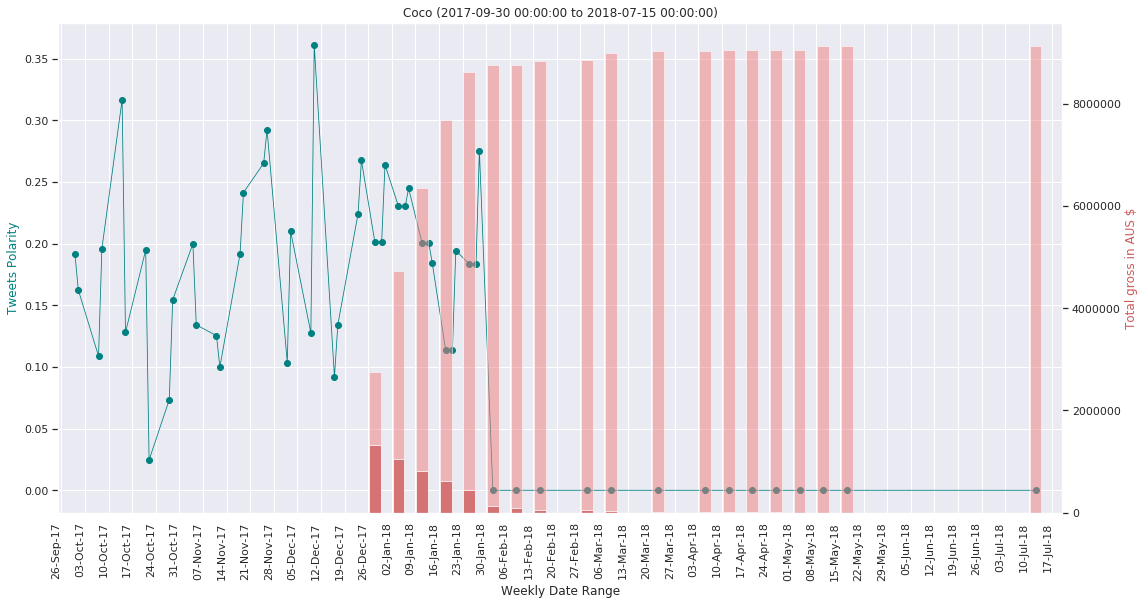

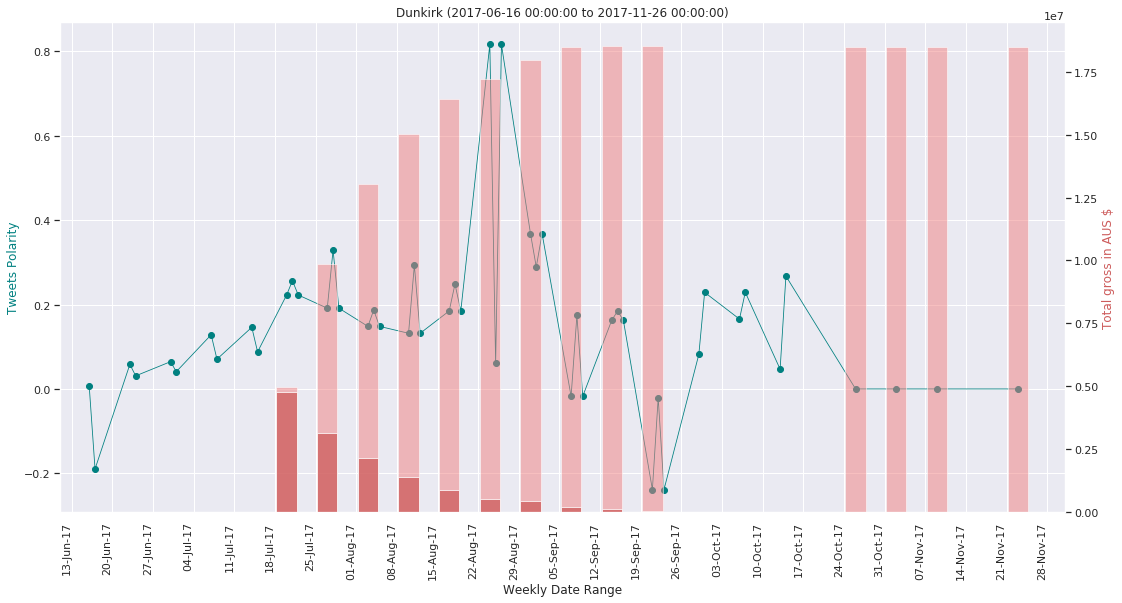

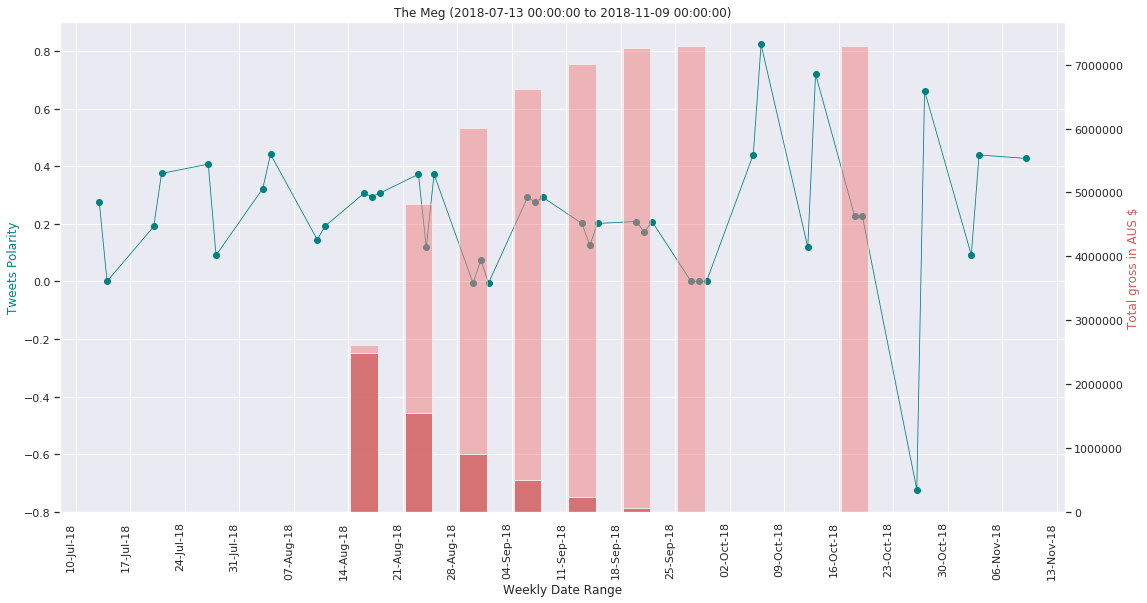

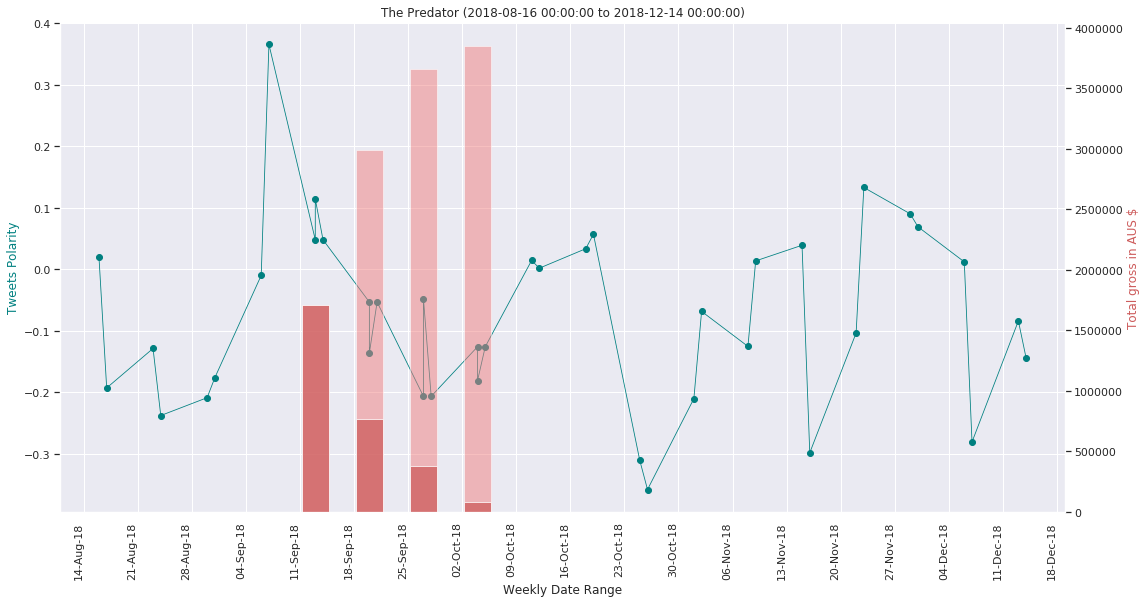

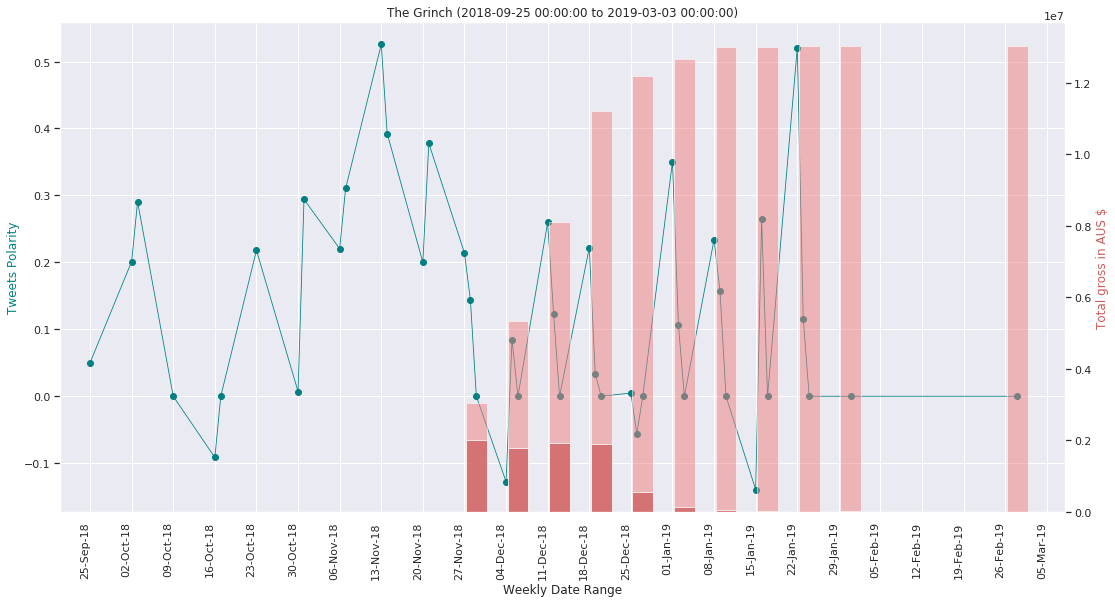

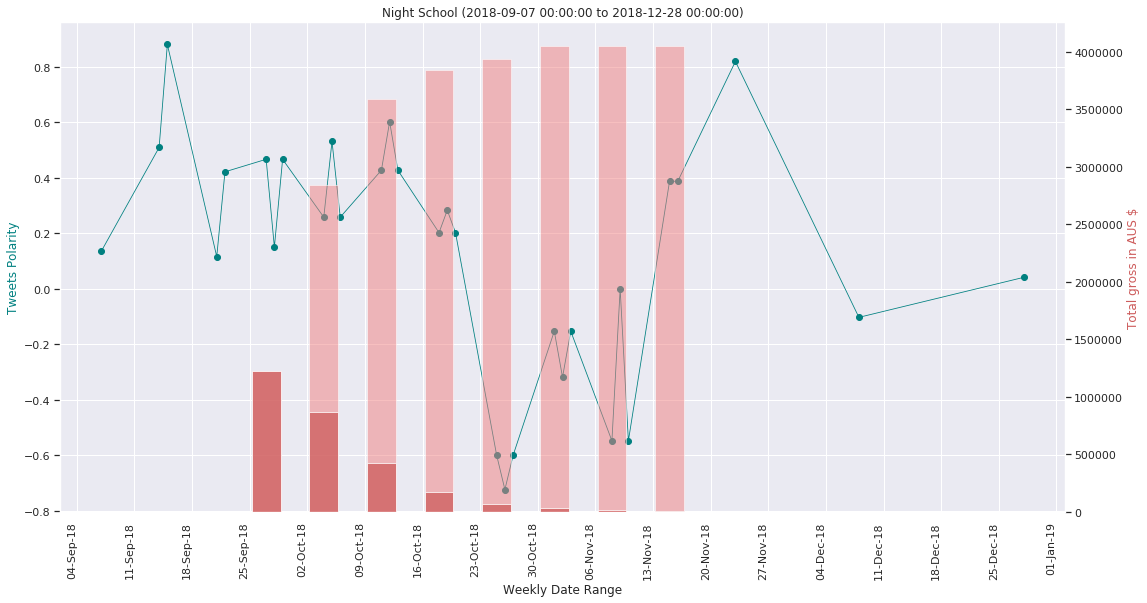

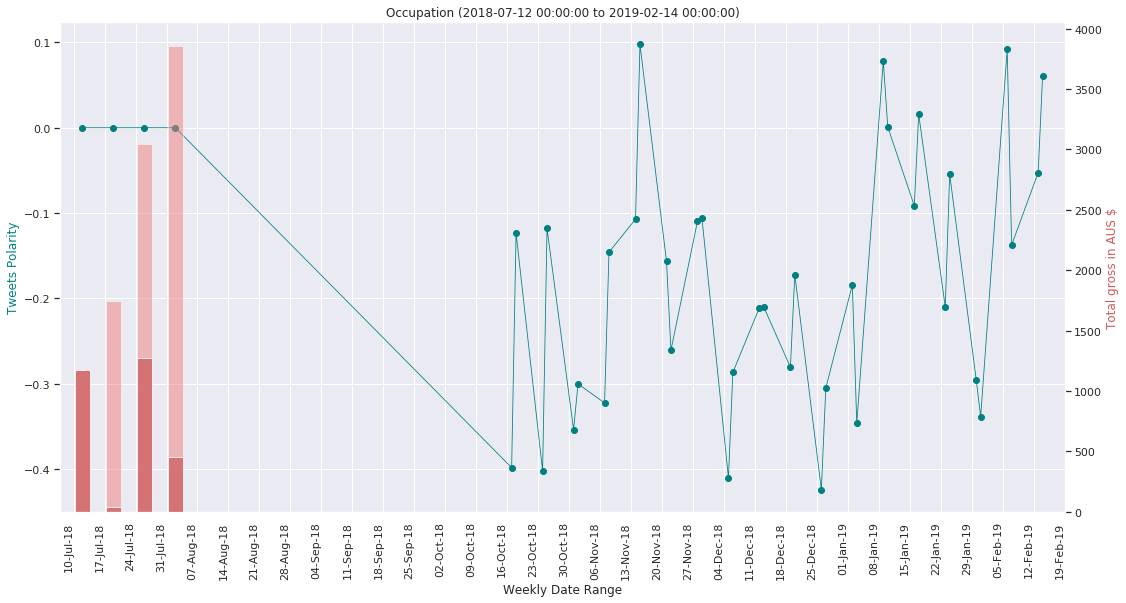

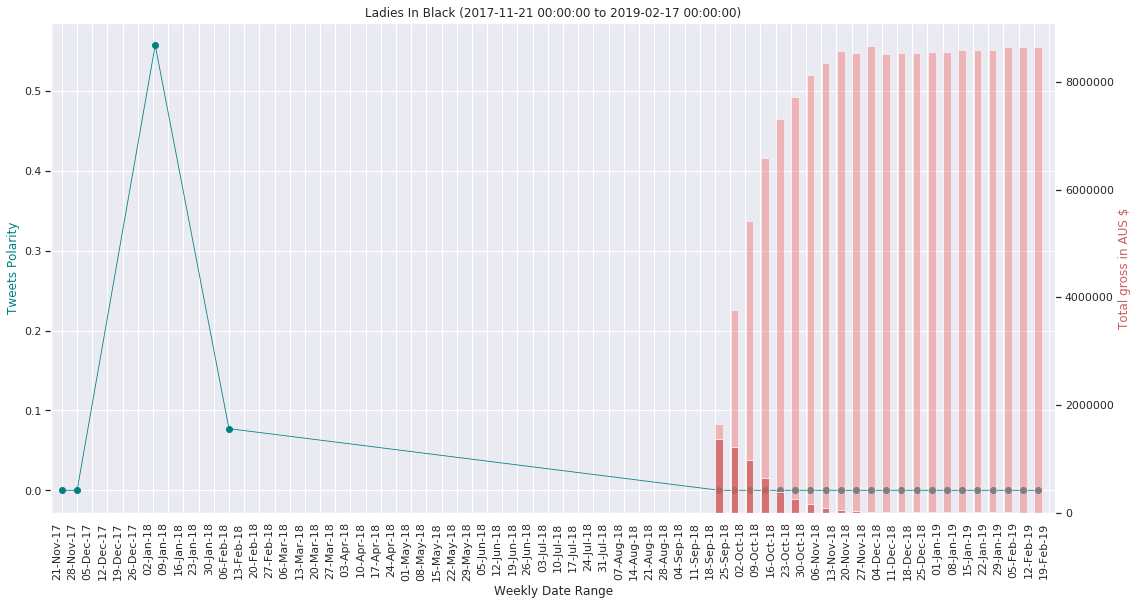

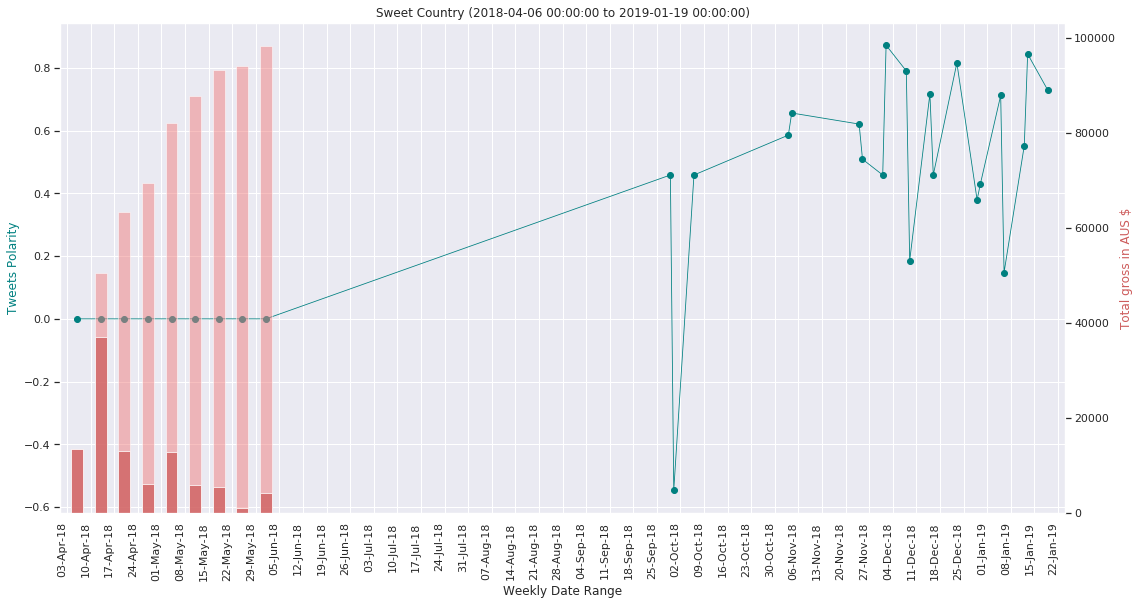

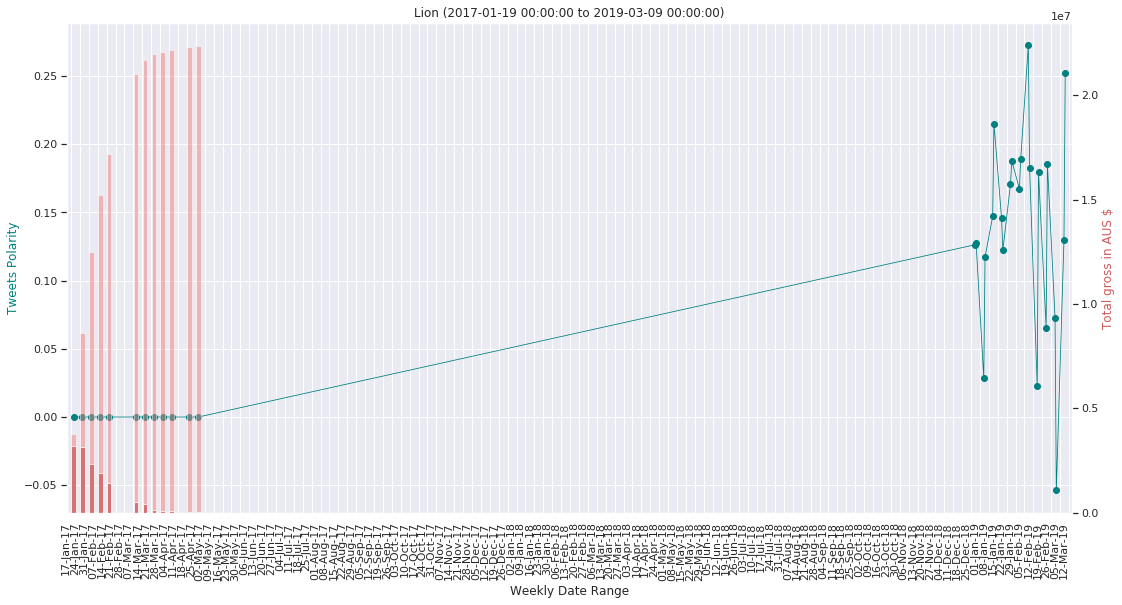

In [43]:
for group in box_vs_sentiment.groupby(['movie_id_t']):
    
    # plot for each movie individually
    # change plotting visual style.
    
    date_form = DateFormatter("%d-%b-%y")
    
    mini = group[1]
    start_date_lim = mini['begin_date'].iloc[0] - datetime.timedelta(days=5)
    end_date_lim = mini['end_date'].iloc[len(mini)-1] + datetime.timedelta(days=5)

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    ax1.set_title("{} ({} to {})".format(string.capwords(mini['Title'].iloc[0]), mini['begin_date'].iloc[0], mini['end_date'].iloc[len(mini)-1]))
    ax1.plot(mini['begin_date'], mini['tweet_sentiment'], color="teal", marker="o", linewidth=0.8)
    ax1.set_ylabel("Tweets Polarity")
    ax1.yaxis.label.set_color('teal')

    ax2 = ax1.twinx()
    ax2.bar(x=mini['begin_date'], height=mini['gross_to_date_float'], width=3.5, alpha=0.5, color="lightcoral")
    ax2.bar(x=mini['begin_date'], height=mini['weekend_gross_float'], width=3.5, alpha=0.75, color="indianred")
    ax2.set_ylabel("Total gross in AUS $")
    ax2.yaxis.label.set_color('indianred')
    ax2.grid(False)

    ax1.set_xlabel("Weekly Date Range")

    # Define the date format
    fig.autofmt_xdate(rotation=90)

    ax1.set_xlim([start_date_lim, end_date_lim])

    ax1.xaxis.set_major_formatter(date_form)
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

### Seasonality/Genre/Influencer effecting sales

#### Seasonality

In [44]:
# perform same heatmap analysis for nth week of the year sales - to get idea about seasonality

by_nth_week = (df_title
              .groupby(['Title', 'nth_week_number'])
              .size()
              .unstack())

for idx in by_nth_week.index:
    for col in by_nth_week.columns:
        
        try:
            by_nth_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['nth_week_number']==col)]['gross_to_date_float'])
        except:
            by_nth_week.at[idx, col] = np.nan

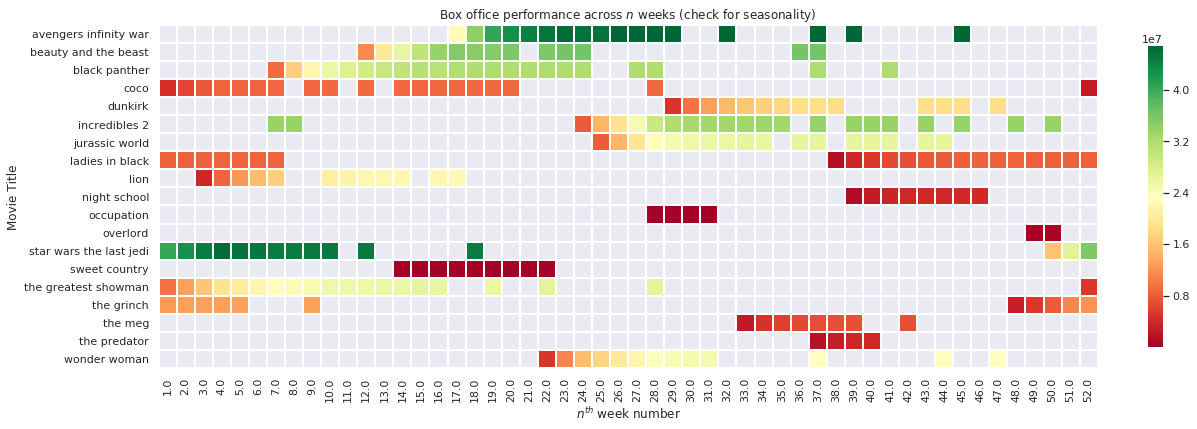

In [53]:
nth_week_releases = sns.heatmap(
    by_nth_week, 
    square=True, 
    cbar_kws={'fraction' : 0.015}, 
    cmap='RdYlGn',
    linewidth=1 
)
nth_week_releases.set_xlabel("$n^{th}$ week number")
nth_week_releases.set_ylabel("Movie Title")
nth_week_releases.set_title("Box office performance across $n$ weeks (check for seasonality)");

#### Influencer

In [46]:
followers_freq = df_sbuzz['user_followers_count'].value_counts(sort=True, ascending=True).to_dict()

In [47]:
max(followers_freq)

10883460

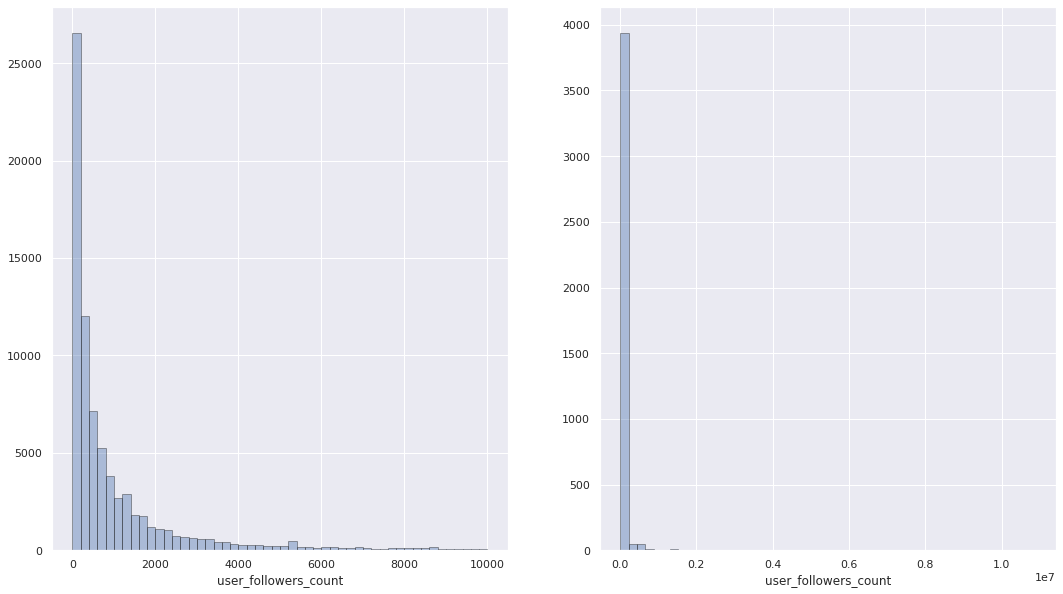

In [48]:
plt.subplot(1, 2, 1)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==False], kde=False, hist_kws=dict(edgecolor="k"));
plt.subplot(1, 2, 2)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==True], kde=False, hist_kws=dict(edgecolor="k"));

# there are some outliers with influencer followers count

### Any time series studies?

------------------------------------------------------------------